In [255]:
import pandas as pd
import numpy as np

In [256]:
cleandata1 = pd.read_csv('dfs_fraud_data_cleaned.xls')
cleandata1

,fraud_bool,income,name_email_similarity,low_name_email_similarity,salary,low_salary_flag,current_address_months_count,low_current_address_tenure,customer_age,days_since_request,...,no_bank_account,name_email_similarity_bin,salary_bin,days_since_request_bin,intended_balcon_bin,velocity_6h_bin,bank_branch_count_8w_bin,low_branch_activity,no_credit_history,mid_range_credit_score
0,0.0,0.8,0.617426,0,105266.0,0,89.0,0,20.0,0,...,0,"(0.6, 0.7]","(92669.0, 105886.0]","(-0.001, 77.0]","(-0.971, -0.829]","(8189.71, 9640.826]","(2.0, 5.0]",0,0,1
1,0.0,0.8,0.996707,0,122830.0,0,14.0,0,40.0,0,...,0,"(0.9, 1.0]","(116512.0, 127334.0]","(-0.001, 77.0]","(-15.532, -1.445]","(3840.293, 4561.279]","(13.0, 17.0]",0,0,1
2,0.0,0.6,0.475100,0,83960.0,0,14.0,0,30.0,0,...,0,"(0.4, 0.5]","(60169.0, 92669.0]","(-0.001, 77.0]","(-15.532, -1.445]","(9640.826, 16715.565]","(9.0, 13.0]",0,0,1
3,0.0,0.9,0.842307,0,146723.0,0,29.0,0,40.0,6,...,0,"(0.8, 0.9]","(139099.0, 150852.0]","(-0.001, 77.0]","(39.933, 112.957]","(7147.653, 8189.71]","(-0.001, 1.0]",1,0,1
4,0.0,0.6,0.294840,0,89627.0,0,369.0,0,30.0,0,...,0,"(0.2, 0.3]","(60169.0, 92669.0]","(-0.001, 77.0]","(-1.257, -1.108]","(9640.826, 16715.565]","(39.0, 753.0]",0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931655,0.0,0.7,0.430227,0,121218.0,0,13.0,0,30.0,0,...,0,"(0.4, 0.5]","(116512.0, 127334.0]","(-0.001, 77.0]","(-1.445, -1.257]","(5321.57, 6149.296]","(753.0, 2385.0]",0,0,0
931656,0.0,0.4,0.828442,0,50592.0,0,35.0,0,20.0,0,...,1,"(0.8, 0.9]","(48956.0, 60169.0]","(-0.001, 77.0]","(-0.662, -0.403]","(2994.143, 3840.293]","(-0.001, 1.0]",1,0,1
931657,0.0,0.8,0.067300,1,110224.0,0,23.0,0,50.0,0,...,0,"(-0.000999, 0.1]","(105886.0, 116512.0]","(-0.001, 77.0]","(-1.445, -1.257]","(9640.826, 16715.565]","(9.0, 13.0]",0,0,0
931658,0.0,0.7,0.175154,1,122308.0,0,35.0,0,40.0,0,...,1,"(0.1, 0.2]","(116512.0, 127334.0]","(-0.001, 77.0]","(-1.257, -1.108]","(4561.279, 5321.57]","(1.0, 2.0]",0,0,0


In [257]:
# Identify continuous (numeric) columns
numeric_cols = cleandata1.select_dtypes(include=['int64', 'float64']).columns

# Create a summary of missingness
missing_summary = (
    cleandata1[numeric_cols]
    .isnull()
    .sum()
    .reset_index()
    .rename(columns={'index': 'column', 0: 'missing_count'})
)

# Add % missing
missing_summary['missing_pct'] = (
    missing_summary['missing_count'] / len(cleandata1) * 100
).round(4)

# Filter to only those with missing values
missing_summary = missing_summary[missing_summary['missing_count'] > 0]

print("---- Missingness in Continuous Columns ----")
print(missing_summary.sort_values(by='missing_pct', ascending=False))

---- Missingness in Continuous Columns ----
         column  missing_count  missing_pct
1        income           4373       0.4694
4        salary           4342       0.4660
8  customer_age            575       0.0617


In [258]:
# Select only categorical columns (object or category dtype)
cat_cols = cleandata1.select_dtypes(include=['object', 'category']).columns

In [259]:
# Fill missing values with the string "Missing"
cleandata1[cat_cols] = cleandata1[cat_cols].fillna('Missing')

In [260]:
from sklearn.feature_selection import VarianceThreshold

cleandata1_nums = cleandata1.select_dtypes(include = ['number'])

# Set your variance threshold 
threshold = 0.01
selector = VarianceThreshold(threshold = threshold)
selector.fit(cleandata1_nums)

,threshold,0.01


In [261]:
# Get list of all column names
flag = selector.get_support()
all_features = cleandata1_nums.columns
low_variability_features = all_features[~flag]

print(low_variability_features.tolist())

[]


In [262]:
# Loop Through Categorical Variables and Look at Top Category %
for col in cleandata1.select_dtypes(include=['object', 'category']):
    top_freq = cleandata1[col].value_counts(normalize=True).iloc[0]
    if top_freq > 0.95:
        print(f"{col} ({top_freq:.1%})")

foreign_request (97.0%)
source (99.0%)
days_since_request_bin (100.0%)


In [263]:
# Remove Variable with Low Variability
cleandata1 = cleandata1.drop(['days_since_request_bin'], axis = 1)

**Test and Train**

In [264]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cleandata1, test_size = 0.25, random_state = 1234)

In [265]:
num_cols = train.select_dtypes(include = 'number').columns

**As a note to Dr.Labarr, we dropped a lot of missing values in continuous variable columns, since there was missingness of less than 1%, there were a select amount of columns that we thought would be resonable to impute. This includes customer_age, salary and income**

In [266]:
# Check if customer_age has missing values
if train['customer_age'].isnull().any():
    # Create missing flag column
    train['customer_age_was_missing'] = train['customer_age'].isnull().astype(int)
    
    # Impute with median
    median_age = train['customer_age'].median()
    train['customer_age'] = train['customer_age'].fillna(median_age)

In [267]:
# Check if salary has missing values
if train['salary'].isnull().any():
    # Create missing flag column
    train['salary'] = train['salary'].isnull().astype(int)
    
    # Impute with median
    median_age = train['salary'].median()
    train['salary'] = train['salary'].fillna(median_age)

In [268]:
# Check if income has missing values
if train['income'].isnull().any():
    # Create missing flag column
    train['income'] = train['income'].isnull().astype(int)
    
    # Impute with median
    median_age = train['income'].median()
    train['income'] = train['income'].fillna(median_age)

**Test and Train is done, so is adding in the col_was_missing**

In [269]:
import statsmodels.api as sm

# Dummy Code the Categorical Variables
predictors = train.drop(columns = ['fraud_bool'])
predictors = pd.get_dummies(predictors, drop_first = True)
predictors = predictors.astype(float)

# Create Predictor and Target Objects
X = predictors
y = train['fraud_bool']

**Now run our chi2 and f_classif test**

In [270]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Separate categorical (dummy) vs. continuous features
categorical_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = [col for col in X.columns if X[col].nunique() > 2]

X_cat = X[categorical_features]
X_cont = X[continuous_features]

In [271]:
# Fit SelectKBest for Categorical Variables
selector = SelectKBest(score_func = chi2, k = 'all')
selector.fit(X_cat, y)

,score_func,<function chi2 at 0x14a187380>
,k,'all'


In [272]:
# Create a DataFrame with feature names, Chi2-scores, and p-values
scores_cat_df = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Sort by Chi2-score descending
scores_cat_df = scores_cat_df.sort_values(by = 'Chi2_score', ascending = False)

with pd.option_context('display.max_rows', None):
    print(scores_cat_df)

                                      Feature   Chi2_score        p_value
7                           high_risk_housing  7252.173138   0.000000e+00
11                           high_risk_device  3106.774646   0.000000e+00
55                          device_os_windows  3106.774646   0.000000e+00
12                 multiple_emails_per_device  1433.202121   0.000000e+00
14                      prev_address_provided  1149.948465  4.603494e-252
57                      keep_alive_session_no  1036.831602  1.772337e-227
1                   low_name_email_similarity   883.668583  3.484260e-194
58                     keep_alive_session_yes   750.383783  3.310956e-165
97            salary_bin_(139099.0, 150852.0]   718.015546  3.615560e-158
47                        has_other_cards_yes   677.840670  1.970183e-149
16                        low_branch_activity   660.100489  1.420626e-145
96            salary_bin_(127334.0, 139099.0]   634.708722  4.728500e-140
38                          housing_st

In [273]:
# Fit SelectKBest for Continuous Variables
selector = SelectKBest(score_func = f_classif, k = 'all')
selector.fit(X_cont, y)

,score_func,<function f_c...t 0x14a1871a0>
,k,'all'


In [274]:
# Create a DataFrame with feature names, F-scores, and p-values
scores_cont_df = pd.DataFrame({
    'Feature': X_cont.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Sort by F-score descending
scores_cont_df = scores_cont_df.sort_values(by = 'F_score', ascending = False)

with pd.option_context('display.max_rows', None):
    print(scores_cont_df)

                             Feature      F_score        p_value
11                 credit_risk_score  3381.320299   0.000000e+00
13             proposed_credit_limit  3264.542934   0.000000e+00
2                       customer_age  2761.153362   0.000000e+00
10  date_of_birth_distinct_emails_4w  1335.864593  3.441707e-292
0              name_email_similarity   928.340777  9.227069e-204
15         device_distinct_emails_8w   912.074490  3.136337e-200
1       current_address_months_count   770.556783  1.683172e-169
4             intended_balcon_amount   411.594184   1.752089e-91
6                        velocity_6h   178.021940   1.325265e-40
8                        velocity_4w    97.213763   6.244767e-23
9               bank_branch_count_8w    92.677159   6.175348e-22
7                       velocity_24h    84.851928   3.224159e-20
14         session_length_in_minutes    50.535547   1.171370e-12
5                       zip_count_4w    14.920015   1.121767e-04
12                 bank_m

**Start HW4 Here**

**Check if we have a rare event for out target variable**

In [275]:
counts = cleandata1['fraud_bool'].value_counts()
percent = cleandata1['fraud_bool'].value_counts(normalize=True) * 100
pd.DataFrame({'Count': counts, 'Percent': percent.round(2)})

,Count,Percent
fraud_bool,,
0.0,921402,98.9
1.0,10258,1.1


In [276]:
# Print absolute counts
print("Counts before undersampling:")
print(train["fraud_bool"].value_counts())

Counts before undersampling:
fraud_bool
0.0    691110
1.0      7635
Name: count, dtype: int64


**Under Sample**

In [277]:
# Separate fraud and non-fraud correctly
fraud = train[train["fraud_bool"] == 1]
non_fraud = train[train["fraud_bool"] == 0]

# Desired ratio: 0.75 (non-fraud) to 0.25 (fraud)
desired_ratio = 0.75 / 0.25  # = 3 non-fraud per 1 fraud

# Calculate how many non-fraud samples we need
n_fraud = len(fraud)
n_non_fraud_desired = int(n_fraud * desired_ratio)

# Randomly undersample the non-fraud class
non_fraud_under = non_fraud.sample(n=n_non_fraud_desired, random_state=1234)

# Combine undersampled non-fraud with all fraud
train_u = pd.concat([non_fraud_under, fraud], axis=0).sample(frac=1, random_state=1234)

# Optional: create a test set with the remaining data
test_u = train.loc[train.index.difference(train_u.index)]

# Check new proportions
print(train_u["fraud_bool"].value_counts(normalize=True))

fraud_bool
0.0    0.75
1.0    0.25
Name: proportion, dtype: float64


In [278]:
# Print absolute counts
print("Counts after undersampling:")
print(train_u["fraud_bool"].value_counts())

# Print proportions
print("\nProportions after undersampling:")
print(train_u["fraud_bool"].value_counts(normalize=True))

Counts after undersampling:
fraud_bool
0.0    22905
1.0     7635
Name: count, dtype: int64

Proportions after undersampling:
fraud_bool
0.0    0.75
1.0    0.25
Name: proportion, dtype: float64


**Next Check For Quasi-Complete Seperation**

In [279]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif


# Separate categorical (dummy) vs. continuous features
categorical_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = [col for col in X.columns if X[col].nunique() > 2]

X_cat = X[categorical_features]
X_cont = X[continuous_features]

# Fit SelectKBest for Categorical Variables
selector = SelectKBest(score_func=chi2, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cat, y)

,score_func,<function chi2 at 0x14a187380>
,k,'all'


In [280]:
# Create a DataFrame with feature names, Chi2-scores, and p-values
scores_cat_df = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.0007
selected_cat_features = scores_cat_df[scores_cat_df['p_value'] < 0.0007]['Feature']

In [281]:
# Fit SelectKBest for Continous Variables
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cont, y)

,score_func,<function f_c...t 0x14a1871a0>
,k,'all'


In [282]:
# Create a DataFrame with feature names, F-scores, and p-values
scores_cont_df = pd.DataFrame({
    'Feature': X_cont.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.0007
selected_cont_features = scores_cont_df[scores_cont_df['p_value'] < 0.0007]['Feature']

# Create a new DataFrame with only those selected columns
X_reduced = X[selected_cat_features.tolist() + selected_cont_features.tolist()]

X_reduced.head()

,low_name_email_similarity,low_salary_flag,low_current_address_tenure,low_zip_activity,very_low_credit_score,high_risk_housing,minimum_credit_limit,low_proposed_credit_limit,high_risk_foreign,high_risk_device,...,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w
453054,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1750.0,11931.076323,4494.515915,4745.736802,9.0,5.0,153.0,200.0,5.0,1.0
12102,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1847.0,8938.820411,6213.313175,6718.114038,20.0,15.0,134.0,200.0,1.0,1.0
810203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1012.0,2452.680569,2787.784559,4274.991940,2.0,5.0,155.0,500.0,4.0,1.0
877656,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,238.0,3592.197874,2549.128672,3155.609104,771.0,9.0,274.0,1000.0,19.0,1.0
422291,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,363.0,7854.212393,4443.994070,4735.267198,748.0,10.0,170.0,500.0,3.0,1.0


In [283]:
def check_quasi_complete_separation(X, y):
    """
    Checks each categorical predictor in X for quasi-complete separation with respect to binary target y.
    
    Parameters:
    - X: pd.DataFrame of predictors (categorical variables)
    - y: pd.Series of binary target variable (e.g., 0/1 or True/False)
    
    Returns:
    - List of variable names that exhibit quasi-complete separation
    """
    problematic_vars = []

    for col in X.columns:
        ct = pd.crosstab(X[col], y)

        # Check if any category (row) has a zero in any outcome class
        if (ct == 0).any(axis=1).any():
            print(f"⚠️ Quasi-complete separation detected in '{col}'")
            print(ct)
            print()
            problematic_vars.append(col)

    return problematic_vars

In [284]:
X_cat_reduced = X_reduced[selected_cat_features.tolist()]

problem_vars = check_quasi_complete_separation(X_cat_reduced, y)

**We have no quasi-complete seperation issues so we will move onto our automatic variable selection**

In [159]:
!pip install mlxtend

In [188]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd

# --- 1. Separate predictors and target from undersampled train set ---
X_train_u = train_u.drop(columns=['fraud_bool'])
y_train_u = train_u['fraud_bool']

# --- 2. Dummy code categorical variables if needed ---
X_train_u = pd.get_dummies(X_train_u, drop_first=True)
X_train_u = X_train_u.astype(float)

# --- 3. Standardize predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_u)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_train_u.columns, index=X_train_u.index)

# --- 4. Logistic Regression model for SFS ---
logr = LogisticRegression(max_iter=1000, solver='newton-cg', penalty=None)

# --- 5. Backward selection ---
sfs = SFS(logr,
          k_features="best",
          forward=False,
          floating=False,
          scoring='roc_auc',
          cv=5)

sfs = sfs.fit(X_scaled_df, y_train_u)  # <-- uses undersampled train_u

# --- 6. Get selected features ---
selected_features = list(sfs.k_feature_names_)
print("Selected features:", selected_features)


Selected features: ['income', 'name_email_similarity', 'low_salary_flag', 'current_address_months_count', 'low_current_address_tenure', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'high_risk_housing', 'bank_months_count', 'proposed_credit_limit', 'minimum_credit_limit', 'high_risk_foreign', 'high_risk_device', 'device_distinct_emails_8w', 'multiple_emails_per_device', 'prev_address_provided', 'no_bank_account', 'low_branch_activity', 'mid_range_credit_score', 'pred_en', 'intended_balcon_anomaly_yes', 'payment_type_AC', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'email_is_free_yes', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_missing', 'phone_home_valid_yes', 'phone_mobile_valid_no', 'has_other_cards_yes', 'source_missing', 'device

In [193]:
selected_features = [f for f in selected_features if f not in ['pred_en', 'p_hat_en']]

In [194]:
import statsmodels.api as sm

# Align X and y
X_selected, y_aligned = X_selected.align(y, join='inner', axis=0)

# Add intercept
X_selected = sm.add_constant(X_selected)

# Fit the logistic regression model
model = sm.Logit(y_aligned, X_selected)
result = model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.346957
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             fraud_bool   No. Observations:                30540
Model:                          Logit   Df Residuals:                    30450
Method:                           MLE   Df Model:                           89
Date:                Thu, 06 Nov 2025   Pseudo R-squ.:                  0.3830
Time:                        19:29:35   Log-Likelihood:                -10596.
converged:                       True   LL-Null:                       -17174.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.8

In [ ]:
# Calculate balanced weights
weight_1 = 1  
weight_0 = (.989/.011) / (.75/.25)  # weight for non-fraud cases

# Apply weights to train_u
train_u['weight'] = train_u['fraud_bool'].replace({1: weight_1, 0: weight_0})

# Prepare features and target from train_u
y_w = train_u['fraud_bool']
X_w = train_u.drop(columns=['fraud_bool', 'weight']).select_dtypes(include=[np.number])

# Add constant term
X_w = sm.add_constant(X_w)

# Fit the weighted model using only train_u data
model_w = sm.GLM(y_w, X_w, family=sm.families.Binomial(), freq_weights=train_u['weight'])
result_w = model_w.fit()
print(result_w.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             fraud_bool   No. Observations:                30540
Model:                            GLM   Df Residuals:                694052.91
Model Family:                Binomial   Df Model:                           37
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32563.
Date:                Thu, 06 Nov 2025   Deviance:                       65126.
Time:                        19:29:40   Pearson chi2:                 6.09e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.4619
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [199]:
from sklearn.metrics import roc_auc_score

# Generate predicted probabilities for the weighted logistic regression
train_u['p_hat_bw'] = result_w.predict(X_w)

# Compute AUC (C-statistic)
auc_bw = roc_auc_score(y_w, train_u['p_hat_bw'])
print(f"C-statistic (AUC): {auc_bw:.4f}")


C-statistic (AUC): 0.8662


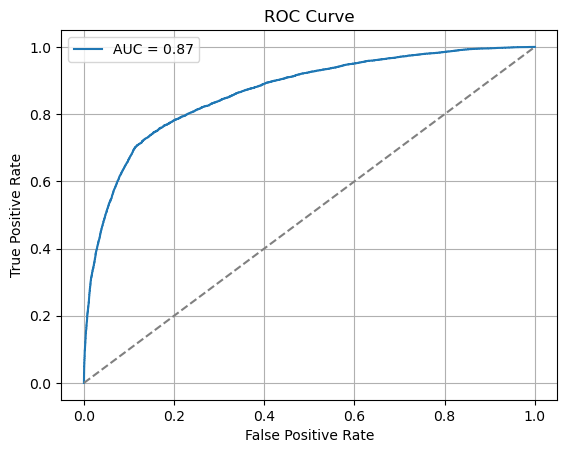

In [200]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(train_u['fraud_bool'], train_u['p_hat_bw'])
fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_bw'])

plt.cla()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [201]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

precision = np.array([])
recall = np.array([])
f1score = np.array([])

for y in range(100):
  train_u['pred_bw'] = train_u['p_hat_bw'].map(lambda x: 1 if x > y/100 else 0)
  value_p = precision_score(train_u['fraud_bool'], train_u['pred_bw'])
  precision = np.append(precision, value_p)
  value_r = recall_score(train_u['fraud_bool'], train_u['pred_bw'])
  recall = np.append(recall, value_r)
  value_f = f1_score(train_u['fraud_bool'], train_u['pred_bw'])
  f1score = np.append(f1score, value_f)

data = {'Precision': precision, 'Recall': recall, 'Cut-off': range(100), 'F1': f1score}
f1_s = pd.DataFrame(data)

f1_s.sort_values(by = ['F1'], ascending = False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Precision,Recall,Cut-off,F1
2,0.677448,0.694041,2,0.685644
1,0.661178,0.710020,1,0.684729
3,0.701391,0.647282,3,0.673251
4,0.745420,0.564898,4,0.642724
5,0.788016,0.477145,5,0.594387
...,...,...,...,...
95,1.000000,0.001441,95,0.002877
96,1.000000,0.000786,96,0.001570
97,1.000000,0.000262,97,0.000524
98,1.000000,0.000131,98,0.000262


In [202]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_bw'])

data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr-fpr}
youden = pd.DataFrame(data)

youden.sort_values(by = ['Youden'], ascending = False)

,TPR,FPR,Cut-off,Youden
3400,0.723903,0.132635,0.008724,0.591268
3398,0.723772,0.132504,0.008730,0.591268
3399,0.723772,0.132635,0.008725,0.591137
3396,0.723510,0.132417,0.008742,0.591094
3450,0.727832,0.136739,0.008433,0.591094
...,...,...,...,...
7079,1.000000,0.995896,0.000988,0.004104
7078,0.999869,0.995896,0.000988,0.003973
1,0.000131,0.000000,0.984289,0.000131
0,0.000000,0.000000,inf,0.000000


In [203]:
threshold = 0.0087
train_u['pred_bw'] = (train_u['p_hat_bw'] > threshold).astype(int)

# Verify predictions were created
print(f"Predictions at threshold {threshold}:")
print(train_u['pred_bw'].value_counts())

Predictions at threshold 0.0087:
pred_bw
0    21964
1     8576
Name: count, dtype: int64


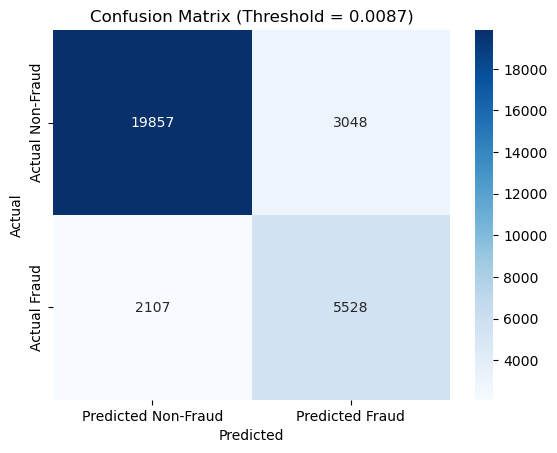

In [204]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_bw'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

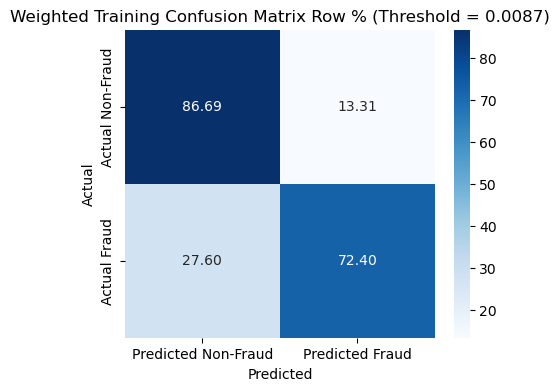

In [205]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Compute confusion matrix ---
cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_bw'])

# --- 2. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 3. Plot confusion matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Weighted Training Confusion Matrix Row % (Threshold = {threshold})')
plt.show()

**Run Logisitc Regression on Test Set**

In [207]:
num_cols = test.select_dtypes(include = 'number').columns

In [208]:
# Check if customer_age has missing values
if test['customer_age'].isnull().any():
    # Create missing flag column
    test['customer_age_was_missing'] = test['customer_age'].isnull().astype(int)
    
    # Impute with median
    median_age = test['customer_age'].median()
    test['customer_age'] = test['customer_age'].fillna(median_age)

In [209]:
# Check if salary has missing values
if test['salary'].isnull().any():
    # Create missing flag column
    test['salary'] = test['salary'].isnull().astype(int)
    
    # Impute with median
    median_age = test['salary'].median()
    test['salary'] = test['salary'].fillna(median_age)

In [210]:
# Check if income has missing values
if test['income'].isnull().any():
    # Create missing flag column
    test['income'] = test['income'].isnull().astype(int)
    
    # Impute with median
    median_age = test['income'].median()
    test['income'] = test['income'].fillna(median_age)

In [211]:
import statsmodels.api as sm

# Dummy Code the Categorical Variables
predictors_t = test.drop(columns = ['fraud_bool'])
predictors_t = pd.get_dummies(predictors, drop_first = True)
predictors_t = predictors.astype(float)

# Create Predictor and Target Objects
X_test = predictors
y_test = test['fraud_bool']

In [212]:
# Get column sets
train_columns = set(X.columns)
test_columns = set(X_test.columns)

# Columns in train but missing in test
missing_in_test = train_columns - test_columns
print("Columns missing in test set:")
print(missing_in_test)

# Columns in test but not in train
extra_in_test = test_columns - train_columns
print("\nExtra columns in test set:")
print(extra_in_test)


Columns missing in test set:
set()

Extra columns in test set:
set()


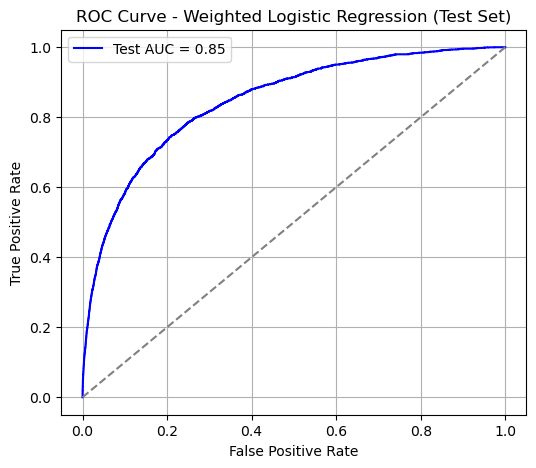

Test ROC-AUC: 0.8462


In [213]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- 1. Prepare X_test (same dummy/encoding logic as training) ---
X_test = test.drop(columns=['fraud_bool'])
X_test = pd.get_dummies(X_test, drop_first=True).astype(float)

# --- 2. Align columns to match training data (X_w) ---
missing_cols = set(X_w.columns) - set(X_test.columns)
missing_cols.discard('const')  # don't add the intercept manually

for col in missing_cols:
    X_test[col] = 0

extra_cols = set(X_test.columns) - set(X_w.columns)
X_test = X_test.drop(columns=extra_cols)

# Reorder to match training predictors (excluding 'const')
X_test = X_test[[col for col in X_w.columns if col != 'const']]

# --- 3. Add intercept (same as in training) ---
import statsmodels.api as sm
X_test = sm.add_constant(X_test)

# --- 4. Predict probabilities using your fitted weighted model ---
y_test = test['fraud_bool'].values
y_pred_proba = result_w.predict(X_test)

# --- 5. Compute ROC-AUC and ROC curve ---
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# --- 6. Plot ROC curve ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Test AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Weighted Logistic Regression (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test ROC-AUC: {auc:.4f}")


In [215]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Arrays to store metrics
precision = np.array([])
recall = np.array([])
f1score = np.array([])

# Loop through thresholds 0.00 to 0.99
for thresh in range(100):
    y_pred_class = (y_pred_proba > thresh / 100).astype(int)
    precision = np.append(precision, precision_score(y_test, y_pred_class))
    recall = np.append(recall, recall_score(y_test, y_pred_class))
    f1score = np.append(f1score, f1_score(y_test, y_pred_class))

# Create DataFrame
f1_s_test = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'Cut-off': range(100),
    'F1': f1score
})

# Sort by F1 descending
f1_s_test_sorted = f1_s_test.sort_values(by='F1', ascending=False)

# Display top thresholds
print(f1_s_test_sorted.head(10))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklea

    Precision    Recall  Cut-off        F1
1    0.102258  0.395349        1  0.162488
2    0.356021  0.051849        2  0.090516
0    0.011262  1.000000        0  0.022272
3    0.566667  0.006481        3  0.012816
4    0.750000  0.001144        4  0.002284
64   0.000000  0.000000       64  0.000000
73   0.000000  0.000000       73  0.000000
72   0.000000  0.000000       72  0.000000
71   0.000000  0.000000       71  0.000000
70   0.000000  0.000000       70  0.000000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [216]:
from sklearn.metrics import roc_curve
import pandas as pd

# --- 1. Compute ROC curve for test set ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# --- 2. Compute Youden's J statistic ---
youden_data = {
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
}

youden_test = pd.DataFrame(youden_data)

# --- 3. Sort by Youden descending to find the optimal threshold ---
youden_test_sorted = youden_test.sort_values(by='Youden', ascending=False)

# --- 4. Display top 10 thresholds ---
print(youden_test_sorted.head(10))


           TPR       FPR   Cut-off    Youden
3694  0.748380  0.210602  0.005629  0.537778
3692  0.747998  0.210450  0.005631  0.537548
3693  0.747998  0.210602  0.005629  0.537396
3690  0.747617  0.210385  0.005631  0.537232
3662  0.742280  0.205074  0.005695  0.537205
3691  0.747617  0.210450  0.005631  0.537167
3686  0.746855  0.209708  0.005639  0.537147
3682  0.746092  0.208965  0.005647  0.537127
3660  0.741899  0.204823  0.005699  0.537076
3688  0.747236  0.210368  0.005631  0.536868


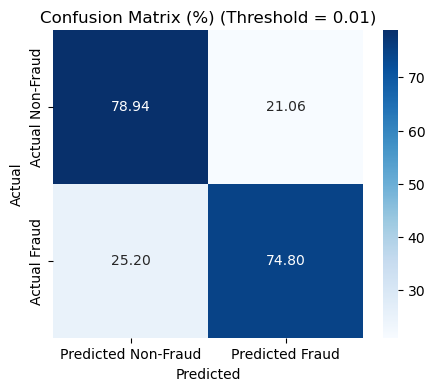

In [217]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Choose threshold from Youden's J
best_threshold = youden_test_sorted.iloc[0]['Cut-off']

# Convert probabilities to class predictions
y_pred_class = (y_pred_proba > best_threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Convert to row percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix as percentages
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix (%) (Threshold = {best_threshold:.2f})')
plt.show()


**Start of Elastic Net**

In [285]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

# --- 1. Prepare predictors and target ---
X_train = train_u.drop(columns=['fraud_bool'])
y_train = train_u['fraud_bool']

# --- 2. Dummy code categorical variables ---
X_train = pd.get_dummies(X_train, drop_first=True)
X_train = X_train.astype(float)

# --- 3. Standardize predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# --- 4. Create sample weights if needed ---
sample_weights = np.where(y_train == 0, 29.97, 1.0)

# --- 5. Fit ElasticNet LogisticRegressionCV ---
elasticnet_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 10),
    cv=5,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0, 0.1, 0.5, 0.7, 0.9, 1.0],
    max_iter=10000,
    scoring='roc_auc',
    random_state=1234,
    n_jobs=-1
)

elasticnet_cv.fit(X_scaled, y_train, sample_weight=sample_weights)

# --- 6. Evaluate ---
y_pred_proba = elasticnet_cv.predict_proba(X_scaled)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_proba)

print(f"C-statistic (ROC-AUC) on train set: {roc_auc:.4f}")
print(f"Best C: {elasticnet_cv.C_[0]:.4f}")
print(f"Best l1_ratio: {elasticnet_cv.l1_ratio_[0]}")


C-statistic (ROC-AUC) on train set: 0.8894
Best C: 0.0464
Best l1_ratio: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score

train_u['p_hat_en'] = elasticnet_cv.predict_proba(X_reduced)[:, 1]

auc = roc_auc_score(y, train_u['p_hat_en'])
print("C-statistic (AUC):", auc)

C-statistic (AUC): 0.8893662056496846


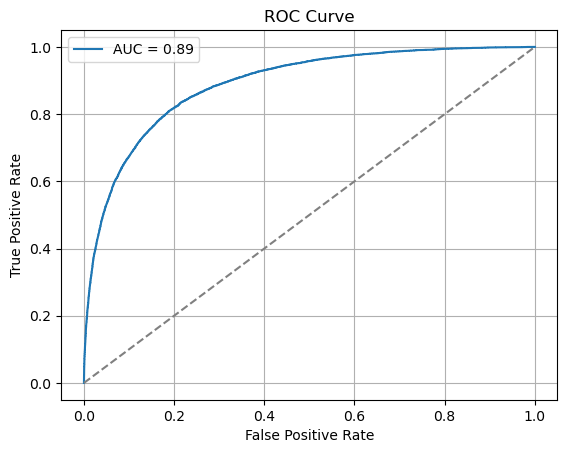

In [132]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(train_u['fraud_bool'], train_u['p_hat_en'])
fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_en'])

plt.cla()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [133]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

precision = np.array([])
recall = np.array([])
f1score = np.array([])

for y in range(100):
  train_u['pred_en'] = train_u['p_hat_en'].map(lambda x: 1 if x > y/100 else 0)
  value_p = precision_score(train_u['fraud_bool'], train_u['pred_en'])
  precision = np.append(precision, value_p)
  value_r = recall_score(train_u['fraud_bool'], train_u['pred_en'])
  recall = np.append(recall, value_r)
  value_f = f1_score(train_u['fraud_bool'], train_u['pred_en'])
  f1score = np.append(f1score, value_f)

data = {'Precision': precision, 'Recall': recall, 'Cut-off': range(100), 'F1': f1score}
f1_s = pd.DataFrame(data)

f1_s.sort_values(by = ['F1'], ascending = False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklea

,Precision,Recall,Cut-off,F1
2,0.673784,0.698494,2,0.685916
1,0.569697,0.824885,1,0.673943
3,0.732007,0.616765,3,0.669463
4,0.770280,0.547217,4,0.639865
5,0.800214,0.489456,5,0.607395
...,...,...,...,...
95,0.000000,0.000000,95,0.000000
96,0.000000,0.000000,96,0.000000
97,0.000000,0.000000,97,0.000000
98,0.000000,0.000000,98,0.000000


In [134]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_en'])

data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr-fpr}
youden = pd.DataFrame(data)

youden.sort_values(by = ['Youden'], ascending = False)

,TPR,FPR,Cut-off,Youden
4178,0.809561,0.188867,0.011120,0.620694
4180,0.809692,0.189085,0.011108,0.620607
4182,0.809823,0.189260,0.011095,0.620563
4174,0.809168,0.188692,0.011141,0.620476
4176,0.809299,0.188823,0.011130,0.620476
...,...,...,...,...
6678,1.000000,0.989216,0.000088,0.010784
6677,0.999869,0.989216,0.000088,0.010653
1,0.000131,0.000000,0.908892,0.000131
0,0.000000,0.000000,inf,0.000000


In [ ]:
# Check what threshold you want to use (from your F1 or Youden analysis)

threshold = 0.02
train_u['pred_en'] = (train_u['p_hat_en'] > threshold).astype(int)

# Verify predictions were created
print(f"Predictions at threshold {threshold}:")
print(train_u['pred_en'].value_counts())

Predictions at threshold 0.02:
pred_en
0    22625
1     7915
Name: count, dtype: int64


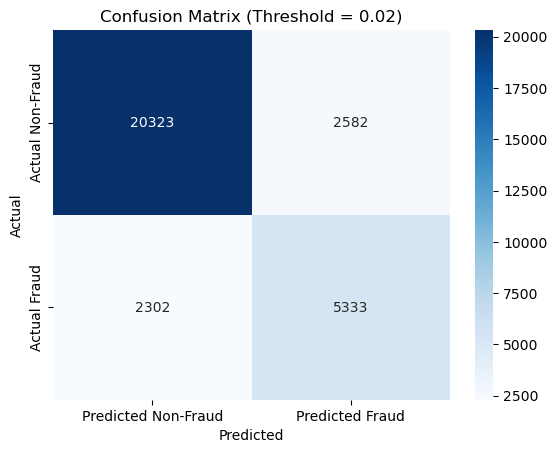

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_en'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

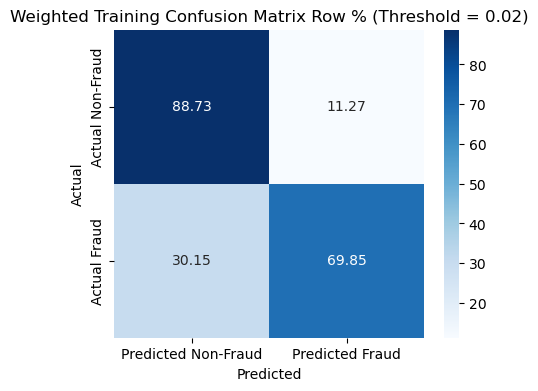

In [157]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Compute confusion matrix ---
cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_en'])

# --- 2. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 3. Plot confusion matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Weighted Training Confusion Matrix Row % (Threshold = {threshold})')
plt.show()


**Run ElasticNet Metrics on Test**

In [141]:
num_cols = test.select_dtypes(include = 'number').columns

In [142]:
# Check if customer_age has missing values
if test['customer_age'].isnull().any():
    # Create missing flag column
    test['customer_age_was_missing'] = test['customer_age'].isnull().astype(int)
    
    # Impute with median
    median_age = test['customer_age'].median()
    test['customer_age'] = test['customer_age'].fillna(median_age)

In [143]:
# Check if salary has missing values
if test['salary'].isnull().any():
    # Create missing flag column
    test['salary'] = test['salary'].isnull().astype(int)
    
    # Impute with median
    median_age = test['salary'].median()
    test['salary'] = test['salary'].fillna(median_age)

In [144]:
# Check if income has missing values
if test['income'].isnull().any():
    # Create missing flag column
    test['income'] = test['income'].isnull().astype(int)
    
    # Impute with median
    median_age = test['income'].median()
    test['income'] = test['income'].fillna(median_age)

In [145]:
import statsmodels.api as sm

# Dummy Code the Categorical Variables
predictors_t = test.drop(columns = ['fraud_bool'])
predictors_t = pd.get_dummies(predictors, drop_first = True)
predictors_t = predictors.astype(float)

# Create Predictor and Target Objects
X_test = predictors
y_test = test['fraud_bool']

In [148]:
# Get column sets
train_columns = set(X.columns)
test_columns = set(X_test.columns)

# Columns in train but missing in test
missing_in_test = train_columns - test_columns
print("Columns missing in test set:")
print(missing_in_test)

# Columns in test but not in train
extra_in_test = test_columns - train_columns
print("\nExtra columns in test set:")
print(extra_in_test)



Columns missing in test set:
set()

Extra columns in test set:
set()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


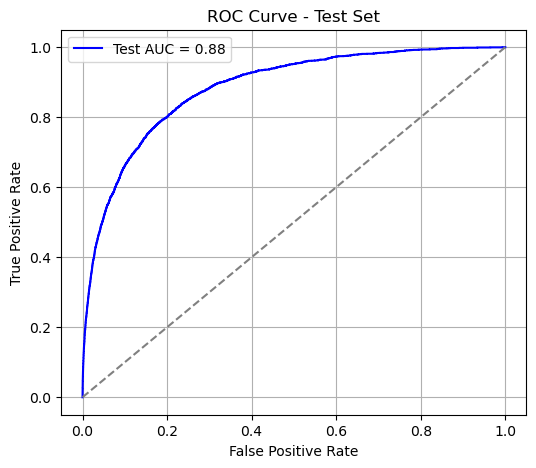

Test ROC-AUC: 0.8835


In [150]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- 1. Prepare X_test ---
X_test = test.drop(columns=['fraud_bool'])
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.astype(float)

# Align columns to training data
missing_cols = set(X_reduced.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
extra_cols = set(X_test.columns) - set(X_reduced.columns)
X_test = X_test.drop(columns=extra_cols)
X_test = X_test[X_reduced.columns]  # reorder columns

# --- 2. Scale test set with training scaler ---
X_test_scaled = scaler.transform(X_test)

# --- 3. Predict probabilities ---
y_test = test['fraud_bool'].values
y_pred_proba = logit_cv.predict_proba(X_test_scaled)[:, 1]

# --- 4. Compute ROC-AUC and ROC curve ---
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# --- 5. Plot ROC curve ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Test AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test ROC-AUC: {auc:.4f}")


In [151]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Arrays to store metrics
precision = np.array([])
recall = np.array([])
f1score = np.array([])

# Loop through thresholds 0.00 to 0.99
for thresh in range(100):
    # Convert probability to binary prediction using threshold
    y_pred_class = (y_pred_proba > thresh/100).astype(int)
    
    # Compute precision, recall, f1
    precision = np.append(precision, precision_score(y_test, y_pred_class))
    recall = np.append(recall, recall_score(y_test, y_pred_class))
    f1score = np.append(f1score, f1_score(y_test, y_pred_class))

# Create DataFrame
data = {'Precision': precision,
        'Recall': recall,
        'Cut-off': range(100),
        'F1': f1score}

f1_s_test = pd.DataFrame(data)

# Sort by F1 descending
f1_s_test_sorted = f1_s_test.sort_values(by='F1', ascending=False)

# Display top thresholds
print(f1_s_test_sorted.head(10))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklea

    Precision    Recall  Cut-off        F1
15   0.243944  0.218833       15  0.230707
12   0.203285  0.264201       12  0.229775
13   0.215169  0.245520       13  0.229345
11   0.191932  0.284788       11  0.229317
14   0.228311  0.228746       14  0.228528
10   0.181572  0.307282       10  0.228264
16   0.255958  0.204727       16  0.227494
17   0.270081  0.191003       17  0.223761
9    0.169174  0.330156        9  0.223715
8    0.158261  0.363706        8  0.220553


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [152]:
from sklearn.metrics import roc_curve
import pandas as pd

# Compute ROC curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute Youden's J statistic
youden_data = {
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
}

youden_test = pd.DataFrame(youden_data)

# Sort by Youden descending to find the optimal threshold
youden_test_sorted = youden_test.sort_values(by='Youden', ascending=False)

# Display top 10 thresholds
print(youden_test_sorted.head(10))


           TPR       FPR   Cut-off    Youden
3656  0.788029  0.183515  0.011668  0.604514
3678  0.792604  0.188100  0.011324  0.604504
3680  0.792985  0.188530  0.011294  0.604455
3676  0.792223  0.187948  0.011332  0.604274
3674  0.791841  0.187679  0.011353  0.604162
3654  0.787648  0.183489  0.011669  0.604159
3655  0.787648  0.183515  0.011668  0.604133
3677  0.792223  0.188100  0.011324  0.604122
3634  0.784217  0.180115  0.011922  0.604102
3682  0.793366  0.189290  0.011250  0.604076


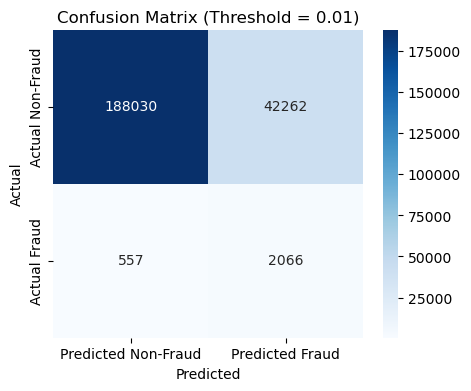

In [153]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Choose a threshold ---
# Example: use threshold that maximizes Youden's J on test set
best_threshold = youden_test_sorted.iloc[0]['Cut-off']

# --- 2. Convert probabilities to class predictions ---
y_pred_class = (y_pred_proba > best_threshold).astype(int)

# --- 3. Compute confusion matrix ---
cm = confusion_matrix(y_test, y_pred_class)

# --- 4. Plot confusion matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.show()


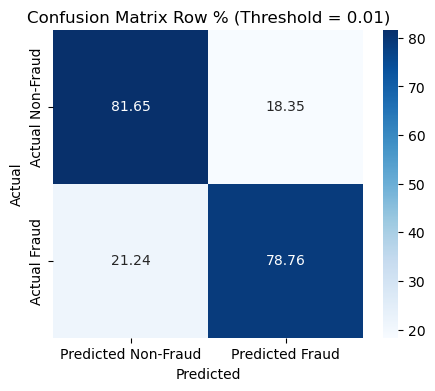

In [156]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Choose a threshold ---
best_threshold = youden_test_sorted.iloc[0]['Cut-off']

# --- 2. Convert probabilities to class predictions ---
y_pred_class = (y_pred_proba > best_threshold).astype(int)

# --- 3. Compute confusion matrix ---
cm = confusion_matrix(y_test, y_pred_class)

# --- 4. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 5. Plot confusion matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix Row % (Threshold = {best_threshold:.2f})')
plt.show()



**Start of LASSO**

In [287]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# --- 1. Prepare predictors and target ---
X_train_l= train_u.drop(columns=['fraud_bool'])
y_train_l = train_u['fraud_bool']

# --- 2. Dummy code categorical variables ---
X_train_l = pd.get_dummies(X_train_l, drop_first=True)
X_train_l = X_train_u.astype(float)

# --- 3. Standardize predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_l)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_train_u.columns, index=X_train_u.index)

# --- 4. Sample weights (if desired) ---
sample_weights = np.where(y_train_l == 0, 29.97, 1.0)

# --- 5. LASSO Logistic RegressionCV (L1 penalty) ---
lasso_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 10),   # grid of C values
    cv=5,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=10000,
    random_state=1234,
    n_jobs=-1
)

# --- 6. Fit the model ---
lasso_cv.fit(X_scaled_df, y_train_l, sample_weight=sample_weights)

# --- 7. Get best C ---
print("Best C (inverse of regularization strength):", lasso_cv.C_[0])

# --- 8. Train set predictions & ROC-AUC ---
train_preds = lasso_cv.predict_proba(X_scaled_df)[:, 1]
train_auc = roc_auc_score(y_train_l, train_preds)
print("Training ROC-AUC:", train_auc)

Best C (inverse of regularization strength): 0.046415888336127774
Training ROC-AUC: 0.8893662056496846


In [370]:
# --- 9. Extract variable names and coefficients ---
coef = lasso_cv.coef_.flatten()
features = X_scaled_df.columns

# Combine into a DataFrame
coef_df = pd.DataFrame({
    'Variable': features,
    'Coefficient': coef
})

# --- 10. Filter to nonzero coefficients ---
nonzero_coef = coef_df[coef_df['Coefficient'] != 0].copy()

# --- 11. Sort by absolute value of coefficient (importance) ---
nonzero_coef['Abs_Coefficient'] = nonzero_coef['Coefficient'].abs()
nonzero_coef = nonzero_coef.sort_values(by='Abs_Coefficient', ascending=False)

# --- 12. Display top predictors ---
print("\nTop 10 Predictive Variables (LASSO):")
print(nonzero_coef.head(10))

# --- 13. Optionally save to CSV ---
nonzero_coef.to_csv("lasso_variable_importance.csv", index=False)

# --- 14. Check sparsity ---
print(f"\nTotal variables: {len(coef_df)}")
print(f"Variables with nonzero coefficients: {len(nonzero_coef)}")



Top 10 Predictive Variables (LASSO):
                      Variable  Coefficient  Abs_Coefficient
30       prev_address_provided    -0.549254         0.549254
19           high_risk_housing     0.424640         0.424640
63         has_other_cards_yes    -0.325271         0.325271
26            high_risk_device     0.299116         0.299116
71           device_os_windows     0.299116         0.299116
28  multiple_emails_per_device     0.290050         0.290050
21       proposed_credit_limit     0.287822         0.287822
17           credit_risk_score     0.272522         0.272522
59        phone_home_valid_yes    -0.244572         0.244572
2    low_name_email_similarity     0.235986         0.235986

Total variables: 147
Variables with nonzero coefficients: 129


In [ ]:
from sklearn.metrics import roc_auc_score

# --- 1. Predicted probabilities from LASSO ---
train_u['p_hat_lasso'] = lasso_cv.predict_proba(X_scaled_df)[:, 1]

# --- 2. Compute ROC-AUC (C-statistic) ---
auc_lasso = roc_auc_score(y_train_l, train_u['p_hat_lasso'])
print("C-statistic (AUC) for LASSO on train_u:", auc_lasso)


C-statistic (AUC) for LASSO on train_u: 0.8893662056496846


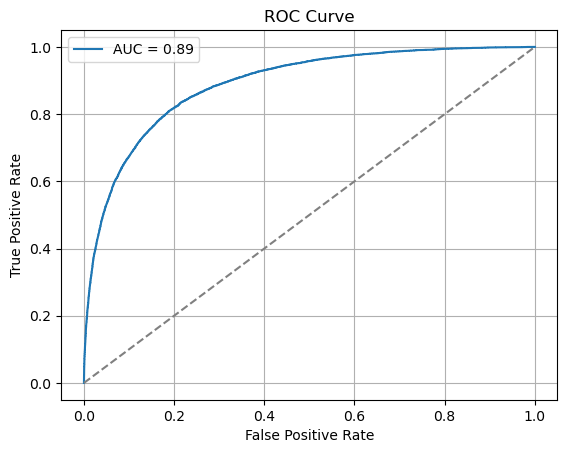

In [289]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(train_u['fraud_bool'], train_u['p_hat_lasso'])
fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_lasso'])

plt.cla()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [290]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

precision = np.array([])
recall = np.array([])
f1score = np.array([])

for y in range(100):
  train_u['pred_lasso'] = train_u['p_hat_lasso'].map(lambda x: 1 if x > y/100 else 0)
  value_p = precision_score(train_u['fraud_bool'], train_u['pred_lasso'])
  precision = np.append(precision, value_p)
  value_r = recall_score(train_u['fraud_bool'], train_u['pred_lasso'])
  recall = np.append(recall, value_r)
  value_f = f1_score(train_u['fraud_bool'], train_u['pred_lasso'])
  f1score = np.append(f1score, value_f)

data = {'Precision': precision, 'Recall': recall, 'Cut-off': range(100), 'F1': f1score}
f1_s = pd.DataFrame(data)

f1_s.sort_values(by = ['F1'], ascending = False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklea

,Precision,Recall,Cut-off,F1
2,0.673784,0.698494,2,0.685916
1,0.569697,0.824885,1,0.673943
3,0.732007,0.616765,3,0.669463
4,0.770280,0.547217,4,0.639865
5,0.800214,0.489456,5,0.607395
...,...,...,...,...
95,0.000000,0.000000,95,0.000000
96,0.000000,0.000000,96,0.000000
97,0.000000,0.000000,97,0.000000
98,0.000000,0.000000,98,0.000000


In [291]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_lasso'])

data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr-fpr}
youden = pd.DataFrame(data)

youden.sort_values(by = ['Youden'], ascending = False)

,TPR,FPR,Cut-off,Youden
4178,0.809561,0.188867,0.011120,0.620694
4180,0.809692,0.189085,0.011108,0.620607
4182,0.809823,0.189260,0.011095,0.620563
4174,0.809168,0.188692,0.011141,0.620476
4176,0.809299,0.188823,0.011130,0.620476
...,...,...,...,...
6678,1.000000,0.989216,0.000088,0.010784
6677,0.999869,0.989216,0.000088,0.010653
1,0.000131,0.000000,0.908892,0.000131
0,0.000000,0.000000,inf,0.000000


In [310]:
# Check what threshold you want to use (from your F1 or Youden analysis)

threshold = 0.011
train_u['pred_lasso'] = (train_u['p_hat_lasso'] > threshold).astype(int)

# Verify predictions were created
print(f"Predictions at threshold {threshold}:")
print(train_u['pred_lasso'].value_counts())

Predictions at threshold 0.011:
pred_lasso
0    19987
1    10553
Name: count, dtype: int64


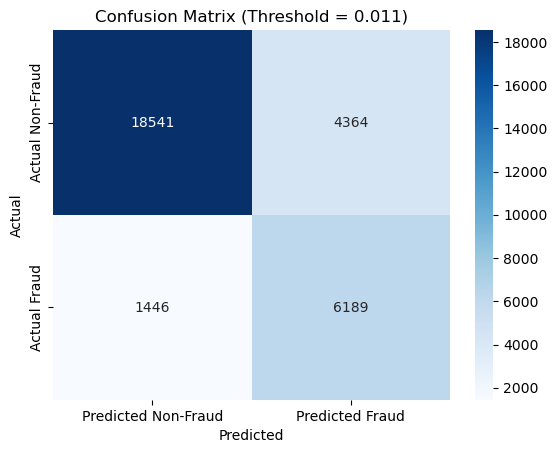

In [311]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_lasso'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

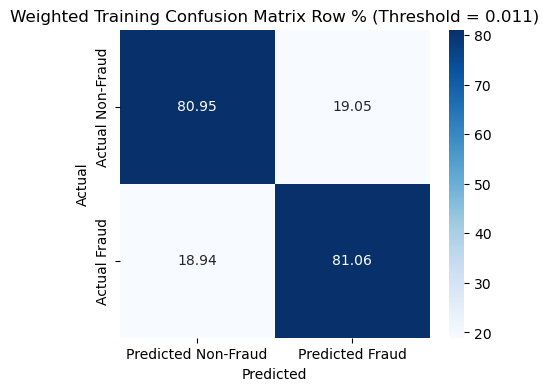

In [312]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Compute confusion matrix ---
cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_lasso'])

# --- 2. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 3. Plot confusion matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Weighted Training Confusion Matrix Row % (Threshold = {threshold})')
plt.show()

**Run LASSO Metrics on Test**

In [296]:
num_cols = test.select_dtypes(include = 'number').columns

In [297]:
# Check if customer_age has missing values
if test['customer_age'].isnull().any():
    # Create missing flag column
    test['customer_age_was_missing'] = test['customer_age'].isnull().astype(int)
    
    # Impute with median
    median_age = test['customer_age'].median()
    test['customer_age'] = test['customer_age'].fillna(median_age)

In [298]:
# Check if salary has missing values
if test['salary'].isnull().any():
    # Create missing flag column
    test['salary'] = test['salary'].isnull().astype(int)
    
    # Impute with median
    median_age = test['salary'].median()
    test['salary'] = test['salary'].fillna(median_age)

In [299]:
# Check if income has missing values
if test['income'].isnull().any():
    # Create missing flag column
    test['income'] = test['income'].isnull().astype(int)
    
    # Impute with median
    median_age = test['income'].median()
    test['income'] = test['income'].fillna(median_age)

In [300]:
import statsmodels.api as sm

# Dummy Code the Categorical Variables
predictors_t = test.drop(columns = ['fraud_bool'])
predictors_t = pd.get_dummies(predictors, drop_first = True)
predictors_t = predictors.astype(float)

# Create Predictor and Target Objects
X_test = predictors
y_test = test['fraud_bool']

In [301]:
# Get column sets
train_columns = set(X.columns)
test_columns = set(X_test.columns)

# Columns in train but missing in test
missing_in_test = train_columns - test_columns
print("Columns missing in test set:")
print(missing_in_test)

# Columns in test but not in train
extra_in_test = test_columns - train_columns
print("\nExtra columns in test set:")
print(extra_in_test)

Columns missing in test set:
set()

Extra columns in test set:
set()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


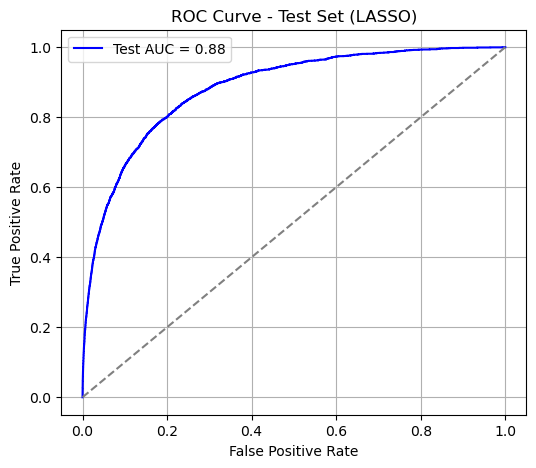

Test ROC-AUC (LASSO): 0.8835


In [302]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- 1. Prepare X_test ---
X_test = test.drop(columns=['fraud_bool'])
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.astype(float)

# Align columns to LASSO training data
missing_cols = set(X_scaled_df.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
extra_cols = set(X_test.columns) - set(X_scaled_df.columns)
X_test = X_test.drop(columns=extra_cols)
X_test = X_test[X_scaled_df.columns]  # reorder columns

# --- 2. Scale test set with training scaler ---
X_test_scaled = scaler.transform(X_test)

# --- 3. Predict probabilities ---
y_test = test['fraud_bool'].values
y_pred_proba = lasso_cv.predict_proba(X_test_scaled)[:, 1]

# --- 4. Compute ROC-AUC and ROC curve ---
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# --- 5. Plot ROC curve ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Test AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set (LASSO)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test ROC-AUC (LASSO): {auc:.4f}")


In [303]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Arrays to store metrics
precision = np.array([])
recall = np.array([])
f1score = np.array([])

# Loop through thresholds 0.00 to 0.99
for thresh in range(100):
    # Convert probability to binary prediction using threshold
    y_pred_class = (y_pred_proba > thresh / 100).astype(int)
    
    # Compute precision, recall, f1
    precision = np.append(precision, precision_score(y_test, y_pred_class))
    recall = np.append(recall, recall_score(y_test, y_pred_class))
    f1score = np.append(f1score, f1_score(y_test, y_pred_class))

# Create DataFrame
data = {
    'Precision': precision,
    'Recall': recall,
    'Cut-off': range(100),
    'F1': f1score
}

f1_s_test = pd.DataFrame(data)

# Sort by F1 descending to find best threshold
f1_s_test_sorted = f1_s_test.sort_values(by='F1', ascending=False)

# Display top 10 thresholds
print(f1_s_test_sorted.head(10))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklea

    Precision    Recall  Cut-off        F1
15   0.243944  0.218833       15  0.230707
12   0.203285  0.264201       12  0.229775
13   0.215169  0.245520       13  0.229345
11   0.191932  0.284788       11  0.229317
14   0.228311  0.228746       14  0.228528
10   0.181572  0.307282       10  0.228264
16   0.255958  0.204727       16  0.227494
17   0.270081  0.191003       17  0.223761
9    0.169174  0.330156        9  0.223715
8    0.158261  0.363706        8  0.220553


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [304]:
from sklearn.metrics import roc_curve
import pandas as pd

# --- 1. Compute ROC curve for LASSO test set ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# --- 2. Compute Youden's J statistic ---
youden_data = {
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
}

youden_test = pd.DataFrame(youden_data)

# --- 3. Sort by Youden descending to find the optimal threshold ---
youden_test_sorted = youden_test.sort_values(by='Youden', ascending=False)

# --- 4. Display top 10 thresholds ---
print(youden_test_sorted.head(10))


           TPR       FPR   Cut-off    Youden
3656  0.788029  0.183515  0.011668  0.604514
3678  0.792604  0.188100  0.011324  0.604504
3680  0.792985  0.188530  0.011294  0.604455
3676  0.792223  0.187948  0.011332  0.604274
3674  0.791841  0.187679  0.011353  0.604162
3654  0.787648  0.183489  0.011669  0.604159
3655  0.787648  0.183515  0.011668  0.604133
3677  0.792223  0.188100  0.011324  0.604122
3634  0.784217  0.180115  0.011922  0.604102
3682  0.793366  0.189290  0.011250  0.604076


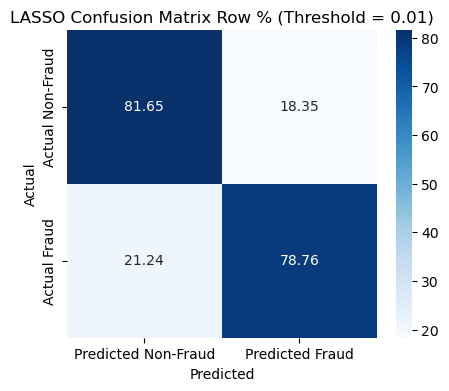

In [306]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Choose a threshold ---
best_threshold = youden_test_sorted.iloc[0]['Cut-off']

# --- 2. Convert probabilities to class predictions ---
y_pred_class = (y_pred_proba > best_threshold).astype(int)

# --- 3. Compute confusion matrix ---
cm = confusion_matrix(y_test, y_pred_class)

# --- 4. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 5. Plot confusion matrix with row percentages ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'LASSO Confusion Matrix Row % (Threshold = {best_threshold:.2f})')
plt.show()


**Start of Decision Tree**

In [ ]:
# -------------------------------
# Complete Weighted Decision Tree with Optuna
# -------------------------------

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna

# -------------------------------
# 1. Prepare predictors and target
# -------------------------------
X_train = train_u.drop(columns=['fraud_bool'])
y_train = train_u['fraud_bool']

# Dummy code categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_train = X_train.astype(float)

# Sample weights for undersampled dataset
sample_weights = np.where(y_train == 0, 29.97, 1.0)

# -------------------------------
# 2. Define Optuna objective
# -------------------------------
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    dt = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=1234
    )

    # 10-fold CV with ROC-AUC, using sample weights
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr = sample_weights[train_idx]

        dt.fit(X_tr, y_tr, sample_weight=w_tr)
        y_pred = dt.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))

    return np.mean(scores)  # mean ROC-AUC across folds

# -------------------------------
# 3. Run Optuna study
# -------------------------------
optuna.logging.set_verbosity(optuna.logging.WARNING)  # suppress per-trial logs
sampler = optuna.samplers.TPESampler(seed=1234)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)  # 50 trials

print("Best parameters found by Optuna:", study.best_params)

# -------------------------------
# 4. Fit final Decision Tree with Gini impurity
# -------------------------------
final_dt = DecisionTreeClassifier(
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    criterion='gini',  # force Gini
    random_state=1234
)

final_dt.fit(X_train, y_train, sample_weight=sample_weights)


y_pred_proba = final_dt.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f"ROC-AUC on train set: {roc_auc:.4f}")




Best parameters found by Optuna: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 9}
ROC-AUC on train set: 0.8568


In [324]:
fraud_dt = DecisionTreeClassifier(
    random_state=1234,
    max_depth=9,
    min_samples_split=6,
    min_samples_leaf=9,
    criterion='gini'
)
fraud_dt.fit(X_train, y_train, sample_weight=sample_weights)


,criterion,'gini'
,splitter,'best'
,max_depth,9
,min_samples_split,6
,min_samples_leaf,9
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1234
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


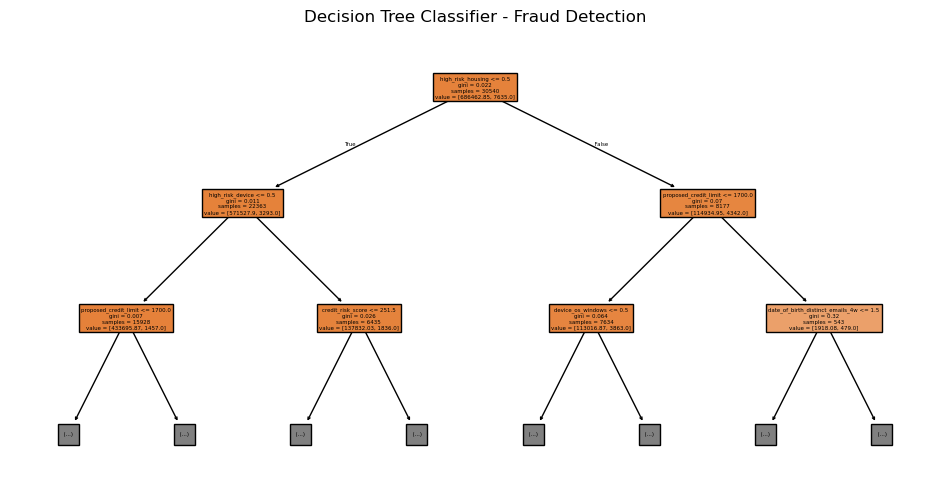

In [326]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 6))
plot_tree(fraud_dt, feature_names=X_train.columns, filled=True, max_depth=2)
plt.title("Decision Tree Classifier - Fraud Detection")
plt.show()


**Variable Importance**

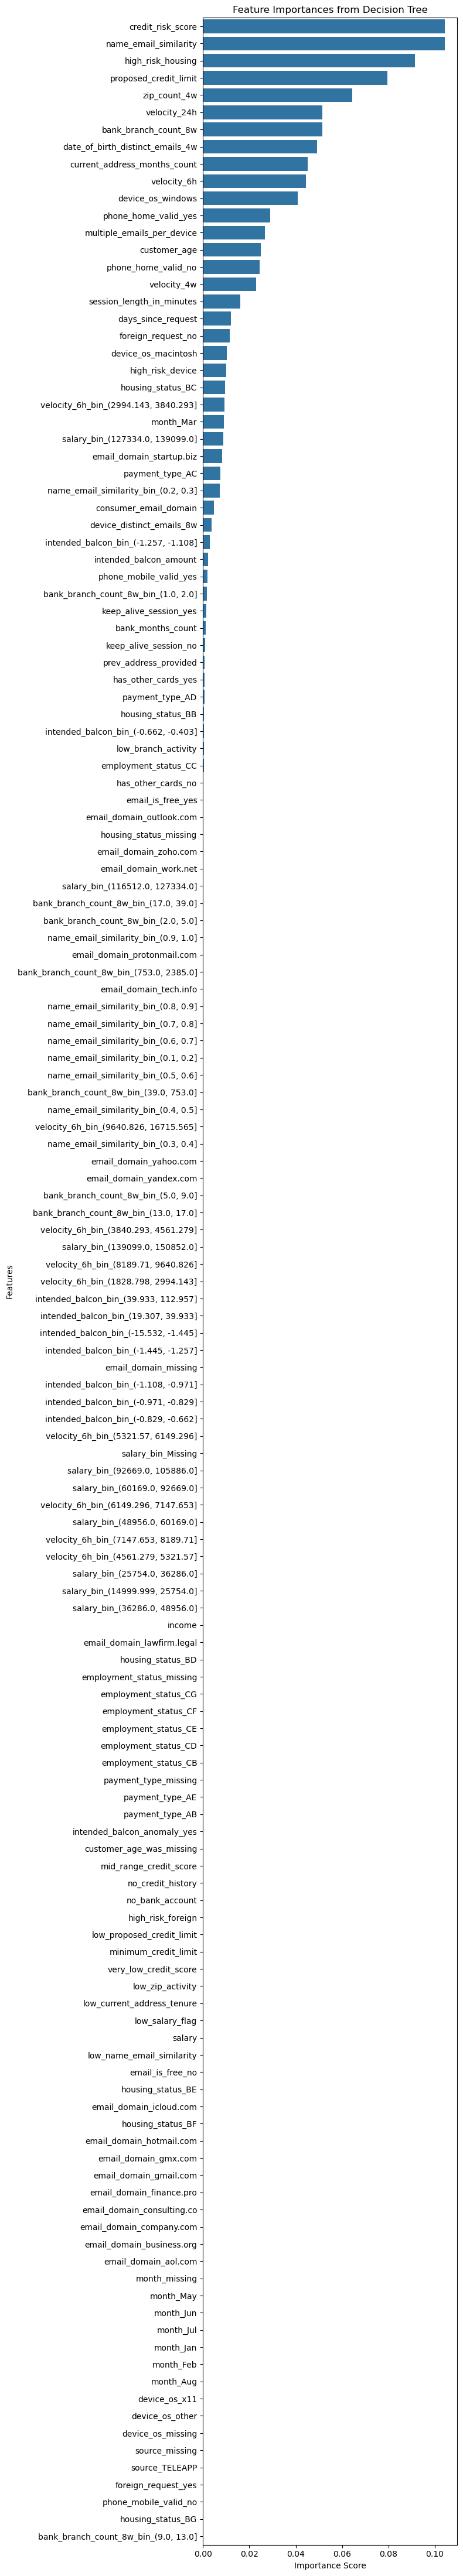

In [327]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Get feature importances ---
importances = fraud_dt.feature_importances_

# --- 2. Create a Series and sort ---
feature_importances = pd.Series(importances, index=X_train.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

# --- 3. Plot ---
plt.figure(figsize=(8, len(sorted_importances) * 0.3))  # dynamic height based on number of features
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title("Feature Importances from Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


**Decision Tree Metrics on Train Data**

In [328]:
from sklearn.metrics import roc_auc_score

# --- 1. Predicted probabilities from Decision Tree ---
train_u['p_hat_dt'] = fraud_dt.predict_proba(X_train)[:, 1]

# --- 2. Compute ROC-AUC (C-statistic) ---
auc_dt = roc_auc_score(y_train, train_u['p_hat_dt'])
print("C-statistic (AUC) for Decision Tree on train_u:", auc_dt)


C-statistic (AUC) for Decision Tree on train_u: 0.8568036537121881


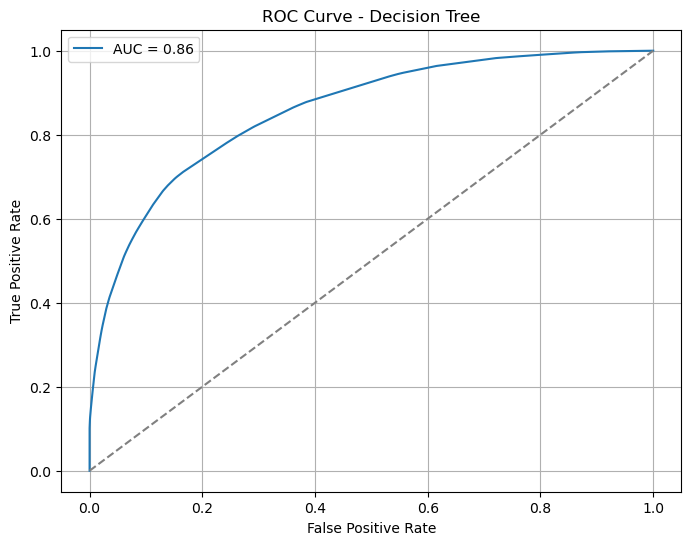

In [329]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Compute ROC-AUC ---
auc_dt = roc_auc_score(train_u['fraud_bool'], train_u['p_hat_dt'])

# --- 2. Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_dt'])

# --- 3. Plot ---
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_dt:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()


In [330]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# --- Initialize arrays ---
precision = np.array([])
recall = np.array([])
f1score = np.array([])

# --- Loop over thresholds from 0 to 0.99 ---
for y in range(100):
    cutoff = y / 100
    train_u['pred_dt'] = train_u['p_hat_dt'].map(lambda x: 1 if x > cutoff else 0)
    
    # Compute metrics
    precision = np.append(precision, precision_score(train_u['fraud_bool'], train_u['pred_dt']))
    recall = np.append(recall, recall_score(train_u['fraud_bool'], train_u['pred_dt']))
    f1score = np.append(f1score, f1_score(train_u['fraud_bool'], train_u['pred_dt']))

# --- Combine into a DataFrame ---
data = {'Precision': precision, 'Recall': recall, 'Cut-off': range(100), 'F1': f1score}
f1_s_dt = pd.DataFrame(data)

# --- Sort by F1 descending to find the best threshold ---
f1_s_dt_sorted = f1_s_dt.sort_values(by='F1', ascending=False)
f1_s_dt_sorted.head(10)  # top 10 thresholds


,Precision,Recall,Cut-off,F1
2,0.632144,0.663523,2,0.647454
1,0.587904,0.711722,1,0.643915
3,0.717958,0.537787,3,0.614947
4,0.758475,0.468893,4,0.579522
5,0.799639,0.406680,5,0.539156
6,0.812397,0.386248,6,0.523569
7,0.838341,0.336215,7,0.479948
8,0.848378,0.315128,8,0.459555
0,0.250369,1.000000,0,0.400472
9,0.885383,0.249902,9,0.389785


In [331]:
from sklearn.metrics import roc_curve
import pandas as pd

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_dt'])

# --- Create DataFrame with Youden's J statistic ---
data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr - fpr}
youden_dt = pd.DataFrame(data)

# --- Sort by Youden's J descending to find optimal threshold ---
youden_dt_sorted = youden_dt.sort_values(by='Youden', ascending=False)
youden_dt_sorted.head(10)  # top 10 thresholds


,TPR,FPR,Cut-off,Youden
74,0.711329,0.165903,0.011441,0.545427
75,0.711722,0.166296,0.011000,0.545427
73,0.701244,0.156210,0.011776,0.545034
72,0.700589,0.155599,0.011988,0.544990
71,0.700065,0.155119,0.012435,0.544947
70,0.697446,0.152805,0.012671,0.544641
69,0.696791,0.152238,0.013436,0.544554
68,0.694172,0.150098,0.014474,0.544073
67,0.679240,0.138791,0.016410,0.540450
66,0.678454,0.138267,0.016410,0.540188


In [332]:
# --- Set threshold based on F1 or Youden analysis ---
threshold = 0.011  # update if you choose a different optimal cutoff
train_u['pred_dt'] = (train_u['p_hat_dt'] > threshold).astype(int)

# --- Verify predictions were created ---
print(f"Predictions at threshold {threshold}:")
print(train_u['pred_dt'].value_counts())


Predictions at threshold 0.011:
pred_dt
0    21309
1     9231
Name: count, dtype: int64


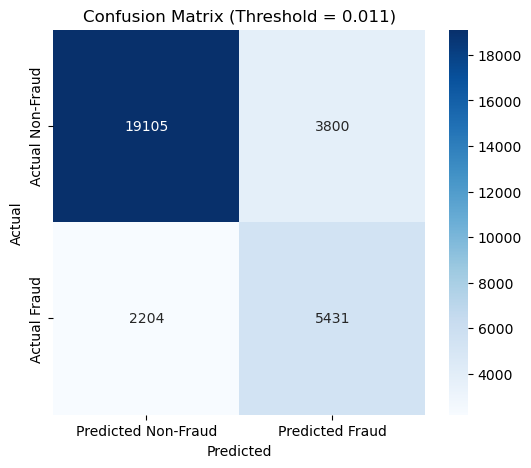

In [333]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Compute confusion matrix ---
cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_dt'])

# --- Plot heatmap ---
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()


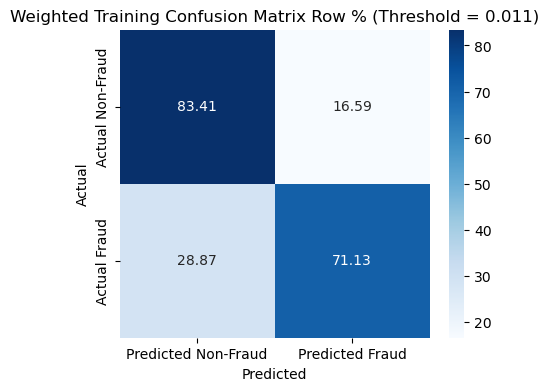

In [334]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Compute confusion matrix ---
cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_dt'])

# --- 2. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 3. Plot confusion matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Weighted Training Confusion Matrix Row % (Threshold = {threshold})')
plt.show()


**Run Decision Tree Metrics on Test Set**

In [335]:
num_cols = test.select_dtypes(include = 'number').columns

In [336]:
# Check if customer_age has missing values
if test['customer_age'].isnull().any():
    # Create missing flag column
    test['customer_age_was_missing'] = test['customer_age'].isnull().astype(int)
    
    # Impute with median
    median_age = test['customer_age'].median()
    test['customer_age'] = test['customer_age'].fillna(median_age)

In [337]:
# Check if salary has missing values
if test['salary'].isnull().any():
    # Create missing flag column
    test['salary'] = test['salary'].isnull().astype(int)
    
    # Impute with median
    median_age = test['salary'].median()
    test['salary'] = test['salary'].fillna(median_age)

In [338]:
# Check if income has missing values
if test['income'].isnull().any():
    # Create missing flag column
    test['income'] = test['income'].isnull().astype(int)
    
    # Impute with median
    median_age = test['income'].median()
    test['income'] = test['income'].fillna(median_age)

In [339]:
import statsmodels.api as sm

# Dummy Code the Categorical Variables
predictors_t = test.drop(columns = ['fraud_bool'])
predictors_t = pd.get_dummies(predictors, drop_first = True)
predictors_t = predictors.astype(float)

# Create Predictor and Target Objects
X_test = predictors
y_test = test['fraud_bool']

In [340]:
# Get column sets
train_columns = set(X.columns)
test_columns = set(X_test.columns)

# Columns in train but missing in test
missing_in_test = train_columns - test_columns
print("Columns missing in test set:")
print(missing_in_test)

# Columns in test but not in train
extra_in_test = test_columns - train_columns
print("\nExtra columns in test set:")
print(extra_in_test)

Columns missing in test set:
set()

Extra columns in test set:
set()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


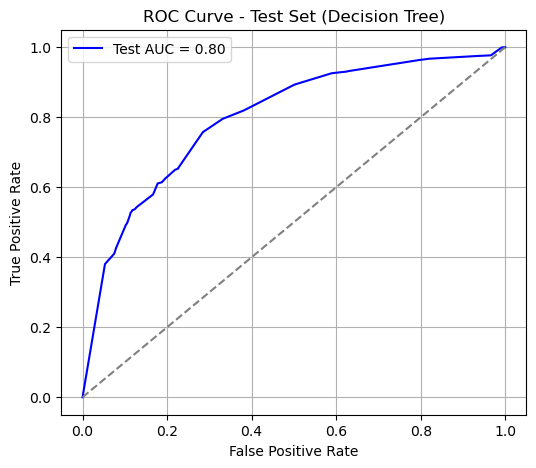

Test ROC-AUC (Decision Tree): 0.7979


In [341]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- 1. Prepare X_test ---
X_test = test.drop(columns=['fraud_bool'])
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.astype(float)

# Align columns to Decision Tree training data
missing_cols = set(X_scaled_df.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
extra_cols = set(X_test.columns) - set(X_scaled_df.columns)
X_test = X_test.drop(columns=extra_cols)
X_test = X_test[X_scaled_df.columns]  # reorder columns

# --- 2. Scale test set if your DT used scaled data (or skip if raw DT) ---
X_test_scaled = scaler.transform(X_test)  # or just X_test if no scaler

# --- 3. Predict probabilities ---
y_test = test['fraud_bool'].values
y_pred_proba = fraud_dt.predict_proba(X_test_scaled)[:, 1]

# --- 4. Compute ROC-AUC and ROC curve ---
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# --- 5. Plot ROC curve ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Test AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set (Decision Tree)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test ROC-AUC (Decision Tree): {auc:.4f}")


In [342]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# --- 1. Predicted probabilities from Decision Tree ---
y_pred_proba = fraud_dt.predict_proba(X_test_scaled)[:, 1]
y_test_labels = y_test  # actual test labels

# --- 2. Arrays to store metrics ---
precision = np.array([])
recall = np.array([])
f1score = np.array([])

# --- 3. Loop through thresholds 0.00 to 0.99 ---
for thresh in range(100):
    # Convert probability to binary prediction using threshold
    y_pred_class = (y_pred_proba > thresh / 100).astype(int)
    
    # Compute precision, recall, f1
    precision = np.append(precision, precision_score(y_test_labels, y_pred_class))
    recall = np.append(recall, recall_score(y_test_labels, y_pred_class))
    f1score = np.append(f1score, f1_score(y_test_labels, y_pred_class))

# --- 4. Create DataFrame ---
data = {
    'Precision': precision,
    'Recall': recall,
    'Cut-off': range(100),
    'F1': f1score
}

f1_s_test = pd.DataFrame(data)

# --- 5. Sort by F1 descending to find best threshold ---
f1_s_test_sorted = f1_s_test.sort_values(by='F1', ascending=False)

# --- 6. Display top 10 thresholds ---
print(f1_s_test_sorted.head(10))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


    Precision   Recall  Cut-off       F1
50    0.07548  0.38048       50  0.12597
75    0.07548  0.38048       75  0.12597
73    0.07548  0.38048       73  0.12597
72    0.07548  0.38048       72  0.12597
71    0.07548  0.38048       71  0.12597
70    0.07548  0.38048       70  0.12597
69    0.07548  0.38048       69  0.12597
68    0.07548  0.38048       68  0.12597
67    0.07548  0.38048       67  0.12597
66    0.07548  0.38048       66  0.12597


In [343]:
from sklearn.metrics import roc_curve
import pandas as pd

# --- 1. Predicted probabilities from Decision Tree ---
y_pred_proba = fraud_dt.predict_proba(X_test_scaled)[:, 1]
y_test_labels = y_test  # actual test labels

# --- 2. Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_proba)

# --- 3. Compute Youden's J statistic ---
youden_data = {
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
}

youden_test = pd.DataFrame(youden_data)

# --- 4. Sort by Youden descending to find the optimal threshold ---
youden_test_sorted = youden_test.sort_values(by='Youden', ascending=False)

# --- 5. Display top 10 thresholds ---
print(youden_test_sorted.head(10))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


         TPR       FPR   Cut-off    Youden
30  0.757530  0.284582  0.011988  0.472947
31  0.757530  0.284595  0.011441  0.472934
32  0.758292  0.285746  0.009859  0.472546
29  0.756767  0.284317  0.014474  0.472450
33  0.795273  0.331297  0.009325  0.463976
34  0.819291  0.381420  0.007990  0.437871
19  0.610751  0.177718  0.030799  0.433033
24  0.649638  0.218688  0.022578  0.430950
22  0.626763  0.197154  0.024590  0.429609
28  0.656500  0.227268  0.016410  0.429232


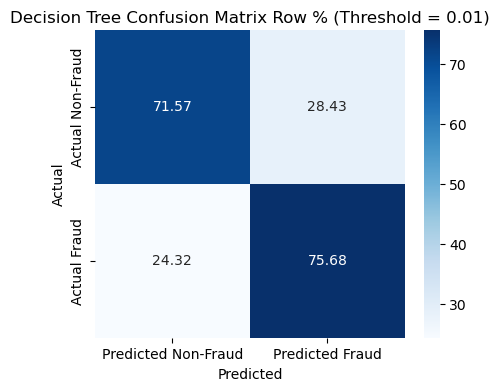

In [344]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Choose a threshold from Youden analysis ---
best_threshold = youden_test_sorted.iloc[0]['Cut-off']

# --- 2. Convert probabilities to class predictions ---
y_pred_class = (y_pred_proba > best_threshold).astype(int)

# --- 3. Compute confusion matrix ---
cm = confusion_matrix(y_test_labels, y_pred_class)

# --- 4. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 5. Plot confusion matrix with row percentages ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Decision Tree Confusion Matrix Row % (Threshold = {best_threshold:.2f})')
plt.show()


**Start of Random Forest**

In [350]:
# -------------------------------
# Complete Weighted Random Forest with Optuna
# -------------------------------

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna

# -------------------------------
# 1. Prepare predictors and target
# -------------------------------
X_train = train_u.drop(columns=['fraud_bool'])
y_train = train_u['fraud_bool']

# Dummy code categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_train = X_train.astype(float)

# Sample weights for undersampled dataset
sample_weights = np.where(y_train == 0, 29.97, 1.0)

# -------------------------------
# 2. Define Optuna objective
# -------------------------------
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 15)
    max_features = trial.suggest_int('max_features', 3, 7)
    n_estimators = trial.suggest_int('n_estimators', 200, 800, step=100)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)

    rf = RandomForestClassifier(
        max_depth=max_depth,
        max_features=max_features,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=1234,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr = sample_weights[train_idx]

        rf.fit(X_tr, y_tr, sample_weight=w_tr)
        y_pred = rf.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))

    return np.mean(scores)

# -------------------------------
# 3. Run Optuna study
# -------------------------------
optuna.logging.set_verbosity(optuna.logging.WARNING)  # suppress per-trial logs
sampler = optuna.samplers.TPESampler(seed=1234)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

print("Best parameters found by Optuna:", study.best_params)

# -------------------------------
# 4. Fit final Random Forest with best parameters
# -------------------------------
final_rf = RandomForestClassifier(
    **study.best_params,
    random_state=1234,
    n_jobs=-1
)

final_rf.fit(X_train, y_train, sample_weight=sample_weights)

# -------------------------------
# 5. Evaluate on training set
# -------------------------------
y_pred_proba = final_rf.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f"ROC-AUC on train set: {roc_auc:.4f}")




Best parameters found by Optuna: {'max_depth': 15, 'max_features': 6, 'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 10}
ROC-AUC on train set: 0.9216


In [351]:
from sklearn.ensemble import RandomForestClassifier

rf_final_weighted = RandomForestClassifier(
    n_estimators = study.best_params['n_estimators'],
    max_features = study.best_params['max_features'],
    max_depth = study.best_params['max_depth'],
    min_samples_split = study.best_params.get('min_samples_split', 2),
    min_samples_leaf = study.best_params.get('min_samples_leaf', 1),
    random_state = 1234,
    n_jobs=-1
)

# Fit on weighted undersampled training set
X_train = pd.get_dummies(train_u.drop(columns=['fraud_bool']), drop_first=True).astype(float)
y_train = train_u['fraud_bool'].values
sample_weights = np.where(y_train == 0, 29.97, 1.0)

rf_final_weighted.fit(X_train, y_train, sample_weight=sample_weights)


,n_estimators,500
,criterion,'gini'
,max_depth,15
,min_samples_split,6
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


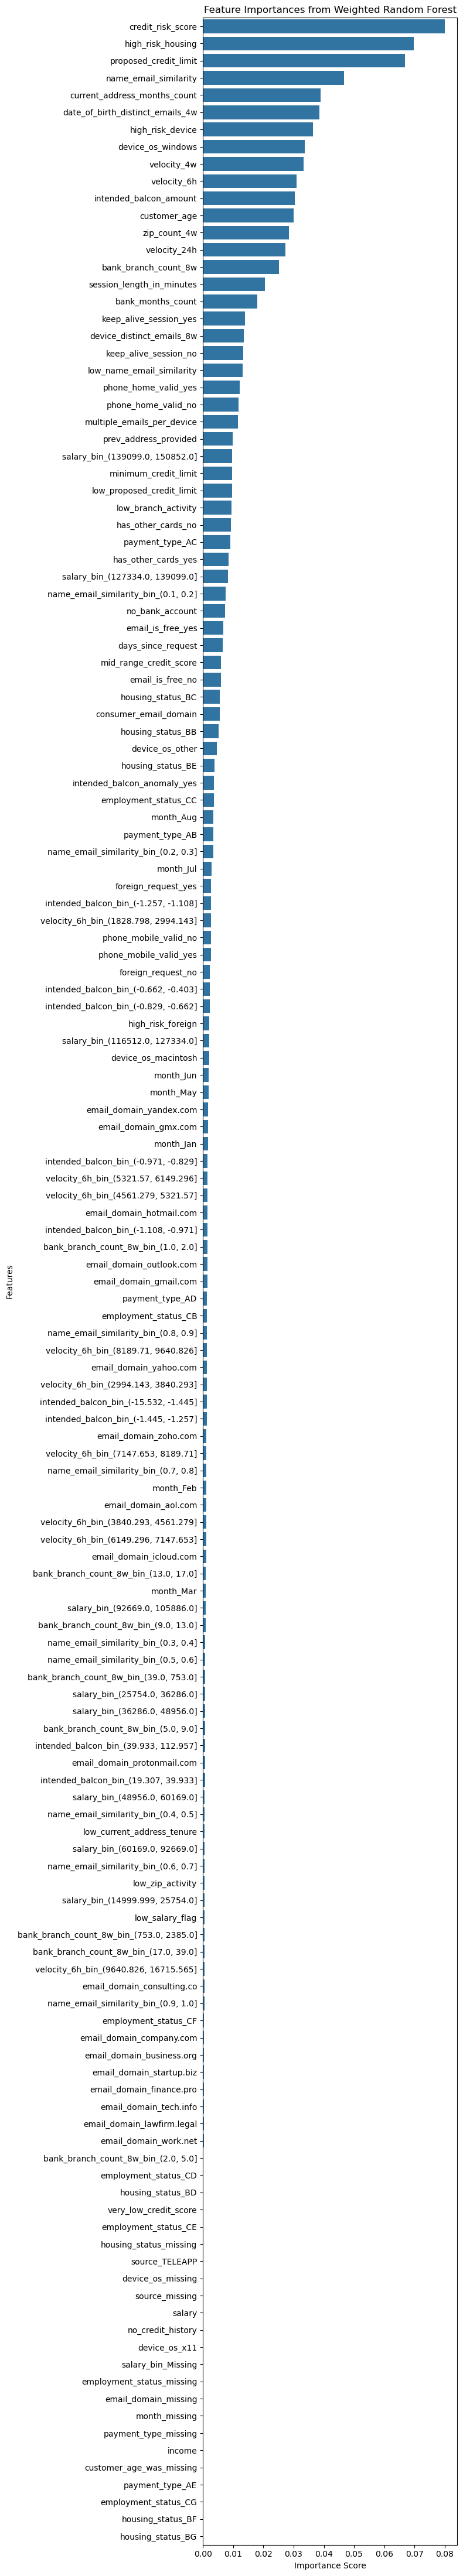

In [352]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure X_train is the same one used for fitting the model
X_train = pd.get_dummies(train_u.drop(columns=['fraud_bool']), drop_first=True).astype(float)

# Get feature importances from your fitted weighted RF
importances = rf_final_weighted.feature_importances_

feature_importances = pd.Series(importances, index=X_train.columns)

# Sort descending
sorted_importances = feature_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, len(sorted_importances) * 0.3))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title("Feature Importances from Weighted Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


/var/folders/0r/tsvw8jf56y5_dgqll9mfqy7c0000gn/T/ipykernel_41819/3971988089.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette=colors)


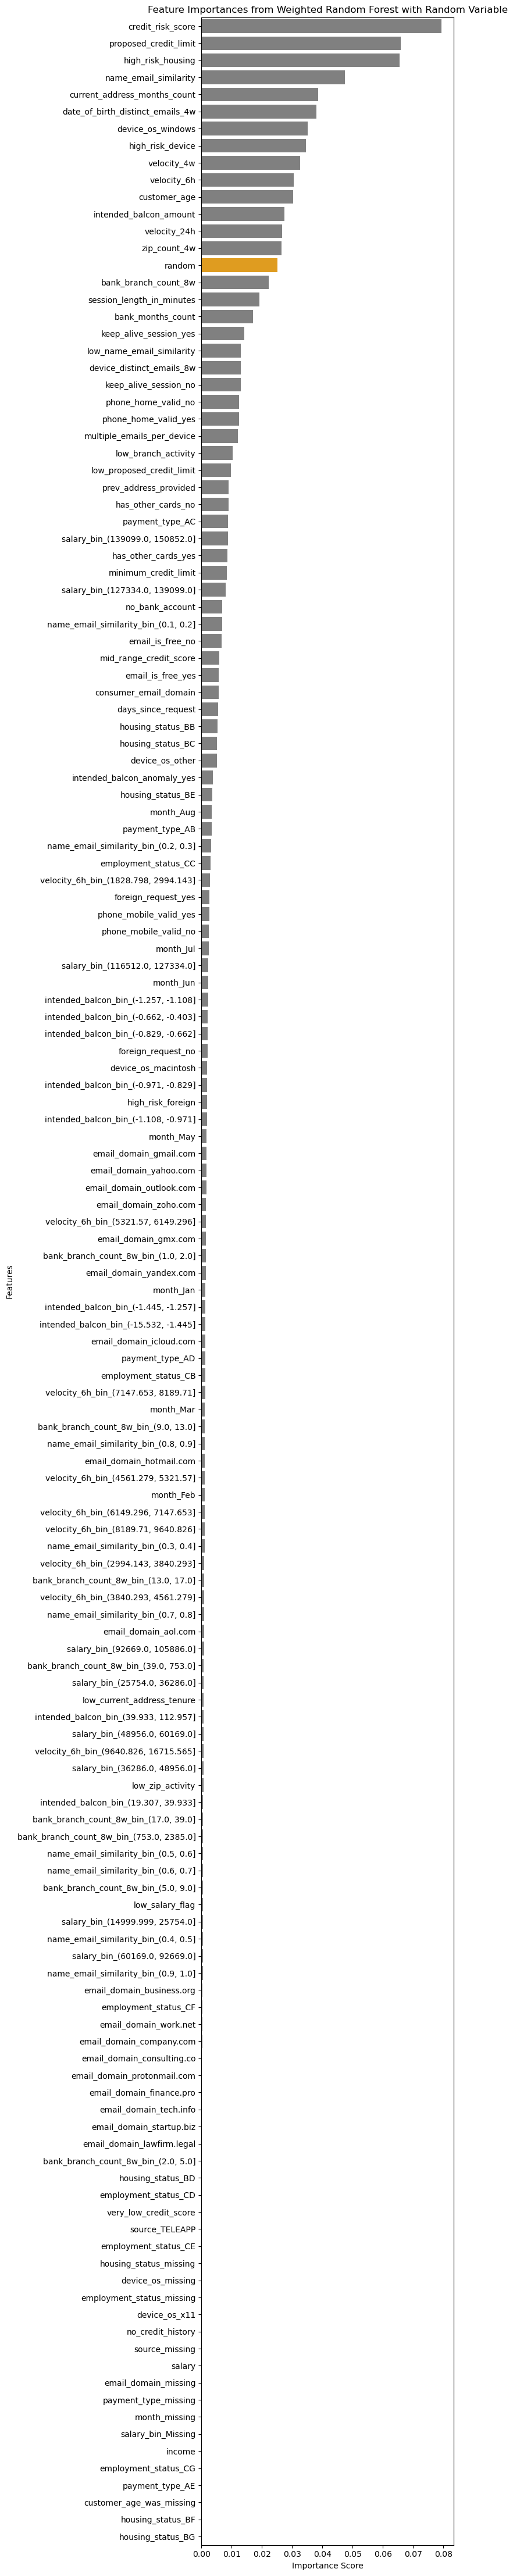

In [353]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -------------------------------
# 1. Prepare X with a random variable
# -------------------------------
X_train_r = X_train.copy()  # X_train from your weighted RF
X_train_r['random'] = np.random.normal(0, 1, X_train.shape[0])

# -------------------------------
# 2. Fit weighted Random Forest with best parameters
# -------------------------------
rf_train_r = RandomForestClassifier(
    **study.best_params,  # your best parameters from Optuna
    random_state=1234,
    n_jobs=-1
)

rf_train_r.fit(X_train_r, y_train, sample_weight=sample_weights)

# -------------------------------
# 3. Get feature importances and sort
# -------------------------------
highlight_feature = 'random'
importances = rf_train_r.feature_importances_
feature_importances = pd.Series(importances, index=X_train_r.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

# -------------------------------
# 4. Define colors for plot
# -------------------------------
colors = ['orange' if feat == highlight_feature else 'gray' for feat in sorted_importances.index]

# -------------------------------
# 5. Plot
# -------------------------------
plt.figure(figsize=(8, len(sorted_importances) * 0.3))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette=colors)
plt.title("Feature Importances from Weighted Random Forest with Random Variable")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


**Random Forest Metrics on Train set**

In [354]:
from sklearn.metrics import roc_auc_score

# --- 1. Predicted probabilities from Random Forest ---
train_u['p_hat_rf'] = final_rf.predict_proba(X_train)[:, 1]  # X_train is what you used to train RF

# --- 2. Compute ROC-AUC (C-statistic) ---
auc_rf = roc_auc_score(y_train, train_u['p_hat_rf'])
print("C-statistic (AUC) for Random Forest on train_u:", auc_rf)


C-statistic (AUC) for Random Forest on train_u: 0.9215869654378075


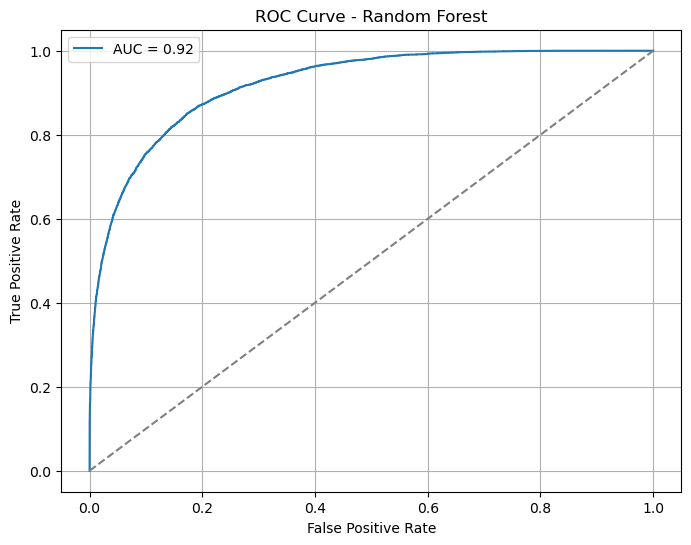

In [355]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Compute ROC-AUC ---
auc_rf = roc_auc_score(train_u['fraud_bool'], train_u['p_hat_rf'])

# --- 2. Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_rf'])

# --- 3. Plot ---
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_rf:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


In [356]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# --- Initialize arrays ---
precision = np.array([])
recall = np.array([])
f1score = np.array([])

# --- Loop over thresholds from 0 to 0.99 ---
for y in range(100):
    cutoff = y / 100
    train_u['pred_rf'] = train_u['p_hat_rf'].map(lambda x: 1 if x > cutoff else 0)
    
    # Compute metrics
    precision = np.append(precision, precision_score(train_u['fraud_bool'], train_u['pred_rf']))
    recall = np.append(recall, recall_score(train_u['fraud_bool'], train_u['pred_rf']))
    f1score = np.append(f1score, f1_score(train_u['fraud_bool'], train_u['pred_rf']))

# --- Combine into a DataFrame ---
data = {'Precision': precision, 'Recall': recall, 'Cut-off': range(100), 'F1': f1score}
f1_s_rf = pd.DataFrame(data)

# --- Sort by F1 descending to find the best threshold ---
f1_s_rf_sorted = f1_s_rf.sort_values(by='F1', ascending=False)
f1_s_rf_sorted.head(10)  # top 10 thresholds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklea

,Precision,Recall,Cut-off,F1
3,0.736856,0.728749,3,0.732780
2,0.637506,0.830386,2,0.721274
4,0.805176,0.639817,4,0.713035
5,0.847345,0.566339,5,0.678913
6,0.885208,0.496922,6,0.636524
1,0.470156,0.947086,1,0.628373
7,0.909165,0.437852,7,0.591054
8,0.929389,0.382711,8,0.542165
9,0.944749,0.338179,9,0.498071
10,0.955274,0.296529,10,0.452574


In [357]:
from sklearn.metrics import roc_curve
import pandas as pd

# --- Compute ROC curve for Random Forest ---
fpr, tpr, thresholds = roc_curve(train_u['fraud_bool'], train_u['p_hat_rf'])

# --- Create DataFrame with Youden's J statistic ---
data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr - fpr}
youden_rf = pd.DataFrame(data)

# --- Sort by Youden's J descending to find optimal threshold ---
youden_rf_sorted = youden_rf.sort_values(by='Youden', ascending=False)
youden_rf_sorted.head(10)  # top 10 thresholds


,TPR,FPR,Cut-off,Youden
3693,0.850426,0.172932,0.018594,0.677494
3697,0.850819,0.173368,0.018548,0.677450
3691,0.850295,0.172888,0.018598,0.677407
3692,0.850295,0.172932,0.018596,0.677363
3695,0.850557,0.173194,0.018572,0.677363
3689,0.850164,0.172844,0.018604,0.677319
3687,0.850033,0.172713,0.018606,0.677319
3690,0.850164,0.172888,0.018602,0.677276
3694,0.850426,0.173194,0.018573,0.677232
3685,0.849902,0.172670,0.018610,0.677232


In [358]:
# --- Set threshold based on F1 or Youden analysis ---
threshold = 0.018594  # update to your chosen optimal cutoff for RF
train_u['pred_rf'] = (train_u['p_hat_rf'] > threshold).astype(int)

# --- Verify predictions were created ---
print(f"Predictions at threshold {threshold}:")
print(train_u['pred_rf'].value_counts())


Predictions at threshold 0.018594:
pred_rf
0    20087
1    10453
Name: count, dtype: int64


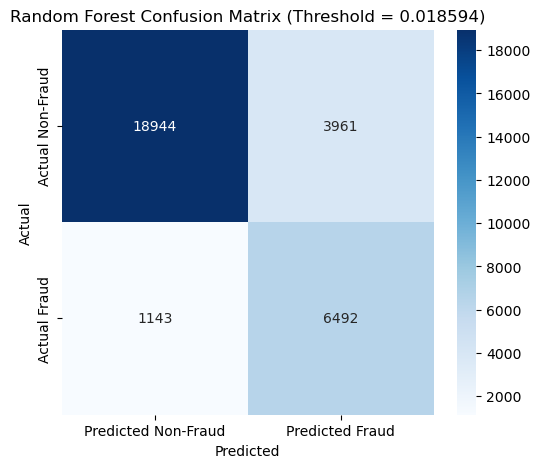

In [359]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Compute confusion matrix for Random Forest ---
cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_rf'])

# --- Plot heatmap ---
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Random Forest Confusion Matrix (Threshold = {threshold})')
plt.show()


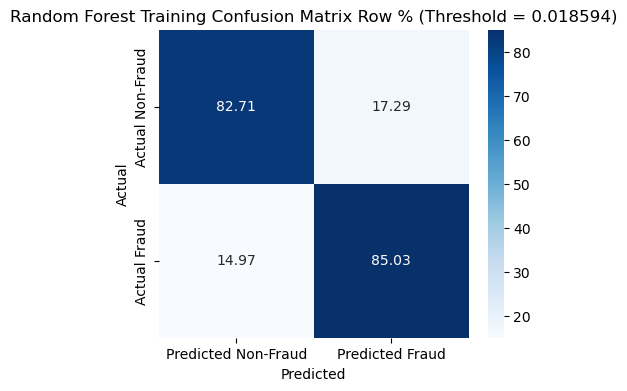

In [360]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Compute confusion matrix for Random Forest ---
cm = confusion_matrix(train_u['fraud_bool'], train_u['pred_rf'])

# --- 2. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 3. Plot confusion matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Random Forest Training Confusion Matrix Row % (Threshold = {threshold})')
plt.show()


**Random Forest Metrics on Test Set**

In [361]:
num_cols = test.select_dtypes(include = 'number').columns

In [362]:
# Check if customer_age has missing values
if test['customer_age'].isnull().any():
    # Create missing flag column
    test['customer_age_was_missing'] = test['customer_age'].isnull().astype(int)
    
    # Impute with median
    median_age = test['customer_age'].median()
    test['customer_age'] = test['customer_age'].fillna(median_age)

In [363]:
# Check if salary has missing values
if test['salary'].isnull().any():
    # Create missing flag column
    test['salary'] = test['salary'].isnull().astype(int)
    
    # Impute with median
    median_age = test['salary'].median()
    test['salary'] = test['salary'].fillna(median_age)

In [364]:
# Check if income has missing values
if test['income'].isnull().any():
    # Create missing flag column
    test['income'] = test['income'].isnull().astype(int)
    
    # Impute with median
    median_age = test['income'].median()
    test['income'] = test['income'].fillna(median_age)

In [365]:
# Get column sets
train_columns = set(X.columns)
test_columns = set(X_test.columns)

# Columns in train but missing in test
missing_in_test = train_columns - test_columns
print("Columns missing in test set:")
print(missing_in_test)

# Columns in test but not in train
extra_in_test = test_columns - train_columns
print("\nExtra columns in test set:")
print(extra_in_test)

Columns missing in test set:
set()

Extra columns in test set:
set()


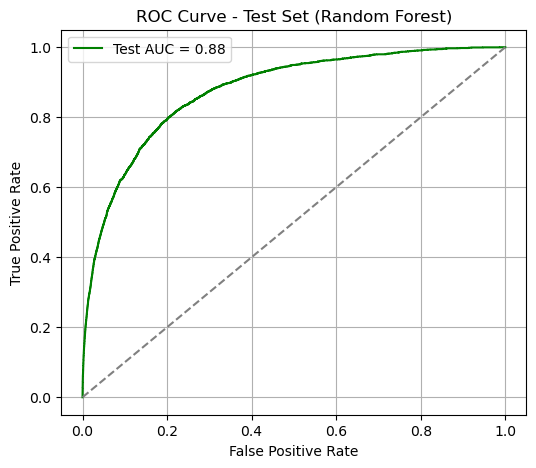

Test ROC-AUC (Random Forest): 0.8765


In [366]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Prepare X_test ---
X_test = test.drop(columns=['fraud_bool'])
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.astype(float)

# Align columns to training data
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
extra_cols = set(X_test.columns) - set(X_train.columns)
X_test = X_test.drop(columns=extra_cols)
X_test = X_test[X_train.columns]  # reorder columns

# --- 2. Predict probabilities with Random Forest ---
y_test = test['fraud_bool'].values
y_pred_proba = final_rf.predict_proba(X_test)[:, 1]

# --- 3. Compute ROC-AUC and ROC curve ---
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# --- 4. Plot ROC curve ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Test AUC = {auc:.2f}", color='green')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test ROC-AUC (Random Forest): {auc:.4f}")


In [367]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# --- 1. Predicted probabilities from Random Forest ---
y_pred_proba = final_rf.predict_proba(X_test)[:, 1]
y_test_labels = y_test  # actual test labels

# --- 2. Arrays to store metrics ---
precision = np.array([])
recall = np.array([])
f1score = np.array([])

# --- 3. Loop through thresholds 0.00 to 0.99 ---
for thresh in range(100):
    cutoff = thresh / 100
    y_pred_class = (y_pred_proba > cutoff).astype(int)
    
    # Compute precision, recall, f1
    precision = np.append(precision, precision_score(y_test_labels, y_pred_class))
    recall = np.append(recall, recall_score(y_test_labels, y_pred_class))
    f1score = np.append(f1score, f1_score(y_test_labels, y_pred_class))

# --- 4. Create DataFrame ---
data = {
    'Precision': precision,
    'Recall': recall,
    'Cut-off': range(100),
    'F1': f1score
}

f1_s_test = pd.DataFrame(data)

# --- 5. Sort by F1 descending to find best threshold ---
f1_s_test_sorted = f1_s_test.sort_values(by='F1', ascending=False)

# --- 6. Display top 10 thresholds ---
print(f1_s_test_sorted.head(10))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklea

    Precision    Recall  Cut-off        F1
10   0.195990  0.264583       10  0.225178
11   0.214691  0.230652       11  0.222386
12   0.238370  0.205109       12  0.220492
9    0.172109  0.297369        9  0.218029
13   0.261573  0.178803       13  0.212409
8    0.152589  0.341594        8  0.210948
14   0.284240  0.157453       14  0.202650
7    0.135587  0.396111        7  0.202022
15   0.309764  0.140297       15  0.193125
6    0.116185  0.447198        6  0.184448


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [368]:
from sklearn.metrics import roc_curve
import pandas as pd

# --- 1. Predicted probabilities from Random Forest ---
y_pred_proba = final_rf.predict_proba(X_test)[:, 1]
y_test_labels = y_test  # actual test labels

# --- 2. Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_proba)

# --- 3. Compute Youden's J statistic ---
youden_data = {
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
}

youden_test = pd.DataFrame(youden_data)

# --- 4. Sort by Youden descending to find the optimal threshold ---
youden_test_sorted = youden_test.sort_values(by='Youden', ascending=False)

# --- 5. Display top 10 thresholds ---
print(youden_test_sorted.head(10))


           TPR       FPR   Cut-off    Youden
3795  0.817003  0.220563  0.017882  0.596440
3701  0.799085  0.202773  0.019283  0.596312
3703  0.799466  0.203177  0.019247  0.596289
3793  0.816622  0.220498  0.017887  0.596124
3697  0.798323  0.202256  0.019328  0.596066
3794  0.816622  0.220563  0.017882  0.596059
3791  0.816241  0.220251  0.017910  0.595990
3699  0.798704  0.202738  0.019285  0.595966
3700  0.798704  0.202773  0.019283  0.595931
3799  0.817766  0.221840  0.017784  0.595926


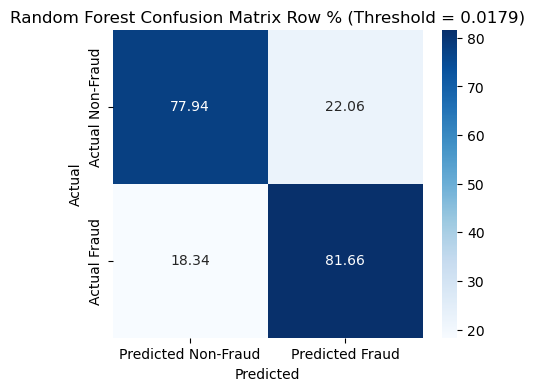

In [369]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Choose a threshold from Youden analysis ---
best_threshold = youden_test_sorted.iloc[0]['Cut-off']

# --- 2. Convert probabilities to class predictions using Random Forest ---
y_pred_class = (y_pred_proba > best_threshold).astype(int)

# --- 3. Compute confusion matrix ---
cm = confusion_matrix(y_test_labels, y_pred_class)

# --- 4. Convert counts to row-wise percentages ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- 5. Plot confusion matrix with row percentages ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'], 
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Random Forest Confusion Matrix Row % (Threshold = {best_threshold:.4f})')
plt.show()
